# Testing a model template

In [38]:
# Packages used for developing models, as well as processing information

from IPython import get_ipython
from IPython.display import display
# %%
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score,f1_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

import csv
from sklearn import tree
from multiprocessing import process


filterwarnings('ignore')

#Class Processing Data

In [39]:
class processing_data:
  def __init__(self,base,label='Processing Dataset'):
    self.base = base
    self.label = label
    self.min_max_scaler = MinMaxScaler()


  def float_values(self, X, str_var):
        for column in str_var:
                try:
                    # Attempt to convert the column to float
                    # If the column is not already of type object (string),
                    # convert it first before applying string operations.
                    X[column] = X[column].astype(str).str.replace(',', '.').astype(float) # Use X instead of self.base
                except ValueError:
                    # If conversion fails, print a message and skip the column
                    print(f"Column '{column}' could not be converted to float. Skipping...")

        return X


  def int_values(self, X, str_var):
        for column in str_var:
                try:
                    # Attempt to convert the column to int
                    #X[column] = X[column].astype(int)
                    X[column]=pd.to_numeric(X[column], errors='coerce').astype(int) #changed column to X[column]
                except ValueError:
                    # If conversion fails, print a message and skip the column
                    print(f"Column '{column}' could not be converted to int. Skipping...")

        return X


  #if my target is a text I transform in dummy value
  #def target_variable(self,X,variavel):
  #  keys = list(self.base[variavel].unique())
  #  my_dict = {}

 #   for i, key in enumerate(keys):
 #     my_dict[key] = i
 #   self.base[variavel] = self.base[variavel].map(my_dict)
 #   return self.base,my_dict

  def target_variable(self,X,variavel,target, multiclass):
    if multiclass == False:
      self.base[variavel] = np.where(self.base[variavel]==target, 1, 0)
      return self.base
    else:
      keys = list(self.base[variavel].unique())
      my_dict = {}

      for i, key in enumerate(keys):
       my_dict[key] = i
      self.base[variavel] = self.base[variavel].map(my_dict)
      #with open('list_variables_markers.txt', 'w') as file:
      # file.write(my_dict)

      # open file for writing, "w" is writing
      w = csv.writer(open("output.csv", "w"))
      # loop over dictionary keys and values
      for key, val in my_dict.items():
      # write every key and value to file
        w.writerow([key, val])
      return self.base


  # transform in dummies some variables
  def dummy_df(self,X,dummies):
      X = pd.get_dummies(X, prefix=dummies, columns=dummies,dtype='int')
      return X

  def normalize_df(self,X,variavel):
    #Normalize the data
    column_to_move = X.pop(variavel)
    X[variavel] = column_to_move

    Lista_variaveis = X.columns[:-1]
    X=X.iloc[:,:-1]
    y=column_to_move.values
    X =pd.DataFrame(data=X, columns=Lista_variaveis)
    min_max_scaler =MinMaxScaler()
    X = self.min_max_scaler.fit_transform(X)
    return X,y,Lista_variaveis

  def impute_values(self, X, type_method):
        # Get the indices of columns with missing values within the impute_values method
        missing_cols_indices = [i for i, col in enumerate(X.columns) if X[col].isnull().any()]
        imputer = SimpleImputer(missing_values=np.nan, strategy=type_method)
        X_df = pd.DataFrame(X, columns = X.columns) # Use X.columns to ensure all columns are included

        # Impute missing values using these indices
        if missing_cols_indices:  # Check if there are any missing columns
            # Reshape the output of fit_transform to match the number of columns
            imputed_data = imputer.fit_transform(X_df[X_df.columns[missing_cols_indices]])
            # Create a DataFrame with the imputed values and correct columns
            #Instead of using X_df.columns[missing_cols_indices] I use X_df.columns[missing_cols_indices].to_list() for creating the dataframe
            imputed_df = pd.DataFrame(imputed_data, columns=X_df.columns[missing_cols_indices].to_list(), index=X_df.index) # Changed this line
            # Update the original DataFrame with the imputed values
            X_df.update(imputed_df)

        return X_df

#Class Models

In [65]:
class models_types:
  def __init__(self,X,y,Lista_variaveis,batch_size=None,epochs=None,cluster=None,model_tree=None):
    self.X = X
    self.y = y
    self.Lista_variaveis = Lista_variaveis
    self.batch_size = batch_size
    self.epochs = epochs
    self.cluster = cluster
    self.model_tree = model_tree
    self.min_max_scaler = MinMaxScaler()
    self.l_encode = LabelEncoder()
    self.l_encode.fit(np.unique(y))

  #Neural Network Model
  def neuro_model(self):
    num_neu= len(self.Lista_variaveis)
    targ=2
    ocult_neu=int((num_neu*(2/3))+2)

    neuro=tf.keras.models.Sequential([tf.keras.layers.Dense(num_neu,input_shape=(len(self.Lista_variaveis),)
                                                  ,activation='relu',kernel_initializer='he_normal'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(ocult_neu,activation='relu',kernel_initializer='he_normal'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(2, activation='softmax')])
    #Train setings
    neuro.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(), #or binary_crossentropy
                metrics=['accuracy'])
    # Return the compiled model instead of the fit history
    return neuro

  def neuro_model_multiclass(self):
      num_neu= len(self.Lista_variaveis)
      #targ=2
      ocult_neu=int((num_neu*(2/3))+2)
      # Get the number of unique classes in the target variable
      num_classes = self.y.shape[1]  # Assuming self.y is one-hot encoded
      neuro=tf.keras.models.Sequential([tf.keras.layers.Dense(num_neu,input_shape=(len(self.Lista_variaveis),)
                                                    ,activation='relu',kernel_initializer='he_normal'),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(ocult_neu,activation='relu',kernel_initializer='he_normal'),
                                tf.keras.layers.Dropout(0.5),
                                # Change the output layer to have num_classes units
                                tf.keras.layers.Dense(num_classes, activation='softmax')])
      #Train setings
      neuro.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(), #or binary_crossentropy
                  metrics=['accuracy'])
      # Return the compiled model instead of the fit history
      return neuro

  def cluster_model(self):
    kmeans = KMeans(n_clusters=self.cluster,init='k-means++',max_iter=300)
    return kmeans

  def tree_and_random_forest(self):
    #Decission Tree Model
    if self.model_tree == 'Decission Tree':
      tree_para = [{'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20]}]
      #GridSearchCV is a powerful tool for finding the best hyperparameters for
      #machine learning models. By using it properly and following best practices,
      #you can significantly improve the performance and accuracy of your models, saving time and effort in the process.

      clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=3)
      clf.fit(self.X,self.y)
      print('Best Parameter to criterion',clf.best_params_['criterion'])
      print('Best Parameter to max_depth',clf.best_params_['max_depth'])
      arvore = DecisionTreeClassifier(criterion=clf.best_params_['criterion'],max_depth=clf.best_params_['max_depth'])
      #tree.plot_tree(arvore.fit(Xtrain,ytrain))
      return arvore

    else:
      #test parameters to check what would be the ideal number of trees and their depth
      tuned_parameters = [{'n_estimators': [20,50,100],
                          'max_depth': [4, 5, 6]}]
      #samples for use in cross_validation
      qt_cv = 3
      clf_rf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv= qt_cv, scoring='roc_auc')
      clf_rf.fit(self.X,self.y)
      RTArray = []
      print('Best Parameter to n_estimators',clf_rf.best_params_['n_estimators'])
      print('Best Parameter to max_depth',clf_rf.best_params_['max_depth'])
      clf_rf = RandomForestClassifier(
                    n_estimators = clf_rf.best_params_['n_estimators'],
                    max_depth = clf_rf.best_params_['max_depth'])

      #clf_rf.fit(Xtrain, ytrain)
      return clf_rf


  def knn_model(self):

    knn_para = [{'n_neighbors':[2,3,4,5],'p':[1,2]}]

    #KNN MODEL
    knn = GridSearchCV(KNeighborsClassifier(), knn_para, cv=3)
    knn.fit(self.X,self.y)
    print('Best Parameter to n_neighbors',knn.best_params_['n_neighbors'])
    print('Best Parameter to p',knn.best_params_['p'])

    knn_f = KNeighborsClassifier(n_neighbors=knn.best_params_['n_neighbors'],p=knn.best_params_['p'])
    return knn_f

  def svm_model(self):
    svm_para = [{'kernel':['linear','poly','sigmoid'],
             'degree':[4,5]}]
    #Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)
    #svm = GridSearchCV(SVC(), svm_para, cv=3)
    #svm.fit(Xtrain,ytrain)
    #print(svm.best_params_)

    #svm_f = SVC(kernel=svm.best_params_['kernel'],degree=svm.best_params_['degree'])
    svm_f = SVC(kernel='rbf',degree=5,probability=True)
    return svm_f

  def logistic_model(self):
    log_para=[{'solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga'],'max_iter':[10,20,50,100,150,200]}]

    log = GridSearchCV(LogisticRegression(), log_para, cv=3)

    log.fit(self.X,self.y)
    print('Best Parameter to solver',log.best_params_['solver'])
    print('Best Parameter to max_inter',log.best_params_['max_iter'])
    log_f = LogisticRegression(solver=log.best_params_['solver'],max_iter=log.best_params_['max_iter'])
    return log_f

  def models_metrics_neuro(self,model, Xtrain,ytrain,Xtest,ytest):
    model.fit(Xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs)
    probs = np.round(model.predict(Xtest, verbose=0)[:,1], 7)
    fpr, tpr, thresholds = roc_curve(ytest, probs)
    #Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
    #This test compares the underlying continuous distributions F(x) and G(x) of two independent samples
    print('\nKS  Validation: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
    print((probs.max(),probs.min()))
    print('\n')
    probs = np.round(model.predict(Xtrain, verbose=0)[:,1], 7)
    fpr, tpr, thresholds = roc_curve(ytrain, probs)
    print('KS Development: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
    print((probs.max(),probs.min()))

  def models_metrics_neuro_multiclass(self, model, Xtrain, ytrain, Xtest, ytest,l_encode_train,l_encode_test):
    # Fit the model
    model.fit(Xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs)

    pred = model.predict(Xtest)
    pred_ = np.argmax(pred, axis=1) # Get the predicted class labels directly from 'pred'
    pred_ = l_encode_test.inverse_transform(pred_) # Use the encoder from 'encode_target'
    true_y =l_encode_test.inverse_transform(np.argmax(ytest, axis=1)) # Correctly decode ytest

    scores = model.evaluate(Xtest, ytest)
    print(f'Test Loss: {scores[0]}')
    print(f'Test Accuracy: {scores[1]}')
    print('\n')
    f1 = f1_score(pred_, true_y)
    print(f'F1 Score: {f1}')
    print('\n')
    recall = recall_score(pred_, true_y)
    print(f'Recall Score: {recall}')
    print('\n')

    # Calculate permutation feature importance using the scoring function
    result = permutation_importance(
        model, Xtest, true_y, n_repeats=10, random_state=0, scoring=self.scoring_fn_multclass
    )
    # Create a DataFrame to store the results
    feature_importances = pd.DataFrame(
        {
            "feature": Lista_variaveis,  # Assuming Lista_variaveis contains feature names
            "importance": result.importances_mean,
        }
    ).sort_values("importance", ascending=False)


    print('\n',feature_importances)

    print('Confussion Matrix')
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(confusion_matrix(true_y, pred_))
    cmp.plot(ax=ax)
    plt.show()


  def models_metrics(self,model, Xtrain,ytrain,Xtest,ytest):
    model.fit(Xtrain, ytrain)
    probs = np.round(model.predict_proba(Xtest)[:,1], 7)

    fpr, tpr, thresholds = roc_curve(ytest, probs)
    print('\n KS Validation: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
    print('\n ',(probs.max(),probs.min()))

    probs = np.round(model.predict_proba(Xtrain)[:,1], 7)
    fpr, tpr, thresholds = roc_curve(ytrain, probs)
    print('\n  KS Development: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
    print('\n',(probs.max(),probs.min()))

  def models_metrics_random_tree(self,model, Xtrain,ytrain,Xtest,ytest):
    model.fit(Xtrain, ytrain)
    #I check how the variables behave in my model, whether they are good or not
    #this can help eliminate some variables and thus select a more precise group of information
    feature_importances = pd.DataFrame(model.feature_importances_,
                                      index = self.Lista_variaveis,
                                        columns=['importance']).sort_values('importance',ascending=False)

    print(feature_importances.count())

    feat_imp_all = feature_importances.sort_values(ascending=True, by='importance')
    graf_all = feat_imp_all.plot(kind = 'barh', color = 'blue', title='Variables', figsize=(15,15), grid = False )

  def models_metrics_log(self,model, Xtrain,ytrain,Xtest,ytest):
    #I can check the variables that were most relevant within my model
    model.fit(Xtrain, ytrain)
    coefficients = model.coef_[0]
    feature_importance = pd.DataFrame({'Feature': self.Lista_variaveis, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

  def models_metrics_svm(self,model, Xtrain,ytrain,Xtest,ytest):
    #I can check the variables that were most relevant within my model
    perm_importance = permutation_importance(model, Xtest, ytest)

    feature_names = self.Lista_variaveis
    features = np.array(feature_names)

    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")

  def scoring_fn_multclass(self, model, X, y):
    y_pred = model.predict(X, verbose=0)  # Get predicted probabilities
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted classes

    # Check if y is already in the correct shape
    if y.ndim == 2 and y.shape[1] > 1:  # If y is one-hot encoded
        y_true_classes = np.argmax(y, axis=1)
    else:  # If y is not one-hot encoded
        y_true_classes = y  # or use your desired method to get true classes

    return accuracy_score(y_true_classes, y_pred_classes)

  def scoring_fn(self,model, X, y):
      y_pred = np.argmax(model.predict(X, verbose=0), axis=1)  # Get predicted classes
      return accuracy_score(y, y_pred)  # Calculate accuracy

  def metrics_class(self,model, Xtrain, ytrain, Xtest, ytest,type_model):
    if type_model =='Decission Tree' or type_model =='Random Forest':
      model.fit(Xtrain, ytrain)
      model_acc = accuracy_score(ytest, model.predict(Xtest))
      print("\nModel Accuracy: {:.2%}".format(model_acc))
      f1 = f1_score(ytest, model.predict(Xtest))
      print("\nF1 Score: {:.2%}".format(f1))
      recall = recall_score(ytest,model.predict(Xtest))
      print("\nRecall Score:{:.2%}".format(recall))
      print('\n')
      print('\nConfussion Matrix')
      fig, ax = plt.subplots(figsize=(10, 10))
      cmp = ConfusionMatrixDisplay(confusion_matrix(ytest, model.predict(Xtest)))
      cmp.plot(ax=ax,cmap = 'inferno')
      plt.show()
      print('\n Feature Importance')
      feature_importances = pd.DataFrame(model.feature_importances_,
                                          index =self.Lista_variaveis,
                                            columns=['importance']).sort_values('importance',ascending=False)
      print(feature_importances.count())
      feat_imp_all = feature_importances.sort_values(ascending=True, by='importance')
      graf_all = feat_imp_all.plot(kind = 'barh', color = 'blue', title='Variables', figsize=(15,15), grid = False )
      if type_model =='Decission Tree':
        tree.plot_tree(model.fit(Xtrain,ytrain))
      return
    elif type_model =='SVM':

      model.fit(Xtrain, ytrain)
      model_acc = accuracy_score(ytest, model.predict(Xtest))
      print("\nModel Accuracy: {:.2%}".format(model_acc))
      f1 = f1_score(ytest, model.predict(Xtest))
      print("\nF1 Score: {:.2%}".format(f1))
      recall = recall_score(ytest,model.predict(Xtest))
      print("\nRecall Score:{:.2%}".format(recall))
      print('\n')
      print('\nConfussion Matrix')
      fig, ax = plt.subplots(figsize=(10, 10))
      cmp = ConfusionMatrixDisplay(confusion_matrix(ytest, model.predict(Xtest)))
      cmp.plot(ax=ax,cmap = 'inferno')
      plt.show()
      print('\n Feature Importance')
      perm_importance = permutation_importance(model, Xtest, ytest)

      feature_names = self.Lista_variaveis
      features = np.array(feature_names)

      sorted_idx = perm_importance.importances_mean.argsort()
      plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
      plt.xlabel("Permutation Importance")
      return

    elif type_model=='Regression Logistic':

      model.fit(Xtrain, ytrain)
      model_acc = accuracy_score(ytest, model.predict(Xtest))
      print("\nModel Accuracy: {:.2%}".format(model_acc))
      f1 = f1_score(ytest, model.predict(Xtest))
      print("\nF1 Score: {:.2%}".format(f1))
      recall = recall_score(ytest,model.predict(Xtest))
      print("\nRecall Score:{:.2%}".format(recall))
      print('\n')
      print('\nConfussion Matrix')
      fig, ax = plt.subplots(figsize=(10, 10))
      cmp = ConfusionMatrixDisplay(confusion_matrix(ytest, model.predict(Xtest)))
      cmp.plot(ax=ax,cmap = 'inferno')
      plt.show()
      print('\n Feature Importance')
      perm_importance = permutation_importance(model, Xtest, ytest)

      feature_names = self.Lista_variaveis
      features = np.array(feature_names)

      sorted_idx = perm_importance.importances_mean.argsort()
      plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
      plt.xlabel("\nPermutation Importance")
      return

    elif type_model == 'KNN':
        model.fit(Xtrain, ytrain)
        model_acc = accuracy_score(ytest, model.predict(Xtest))
        print("\nModel Accuracy: {:.2%}".format(model_acc))
        f1 = f1_score(ytest, model.predict(Xtest))
        print("\nF1 Score: {:.2%}".format(f1))
        recall = recall_score(ytest,model.predict(Xtest))
        print("\nRecall Score:{:.2%}".format(recall))
        print('\n')
        print('\nConfussion Matrix')
        fig, ax = plt.subplots(figsize=(10, 10))
        cmp = ConfusionMatrixDisplay(confusion_matrix(ytest, model.predict(Xtest)))
        cmp.plot(ax=ax, cmap='inferno')
        plt.show()
        print('\n KNN model does not have feature importance') # Print message instead of accessing feature_importances_
        return

    elif type_model=='Neural Network':
        model.fit(Xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs)
        predition_1 = model.predict(Xtest, verbose=0)
        predition_1 = np.argmax(predition_1, axis=1)
        model_acc= accuracy_score(ytest, predition_1)
        print("\nModel Accuracy: {:.2%}".format(model_acc))
        f1 = f1_score(ytest,predition_1)
        print("\nF1 Score: {:.2%}".format(f1))
        recall = recall_score(ytest,predition_1)
        print("\nRecall Score:{:.2%}".format(recall))
        print('\n')
        print('\nConfussion Matrix')
        fig, ax = plt.subplots(figsize=(10, 10))
        cmp = ConfusionMatrixDisplay(confusion_matrix(ytest,predition_1))
        cmp.plot(ax=ax,cmap = 'inferno')
        plt.show()

        # Calculate permutation feature importance using the scoring function
        result = permutation_importance(
            model, Xtest, ytest, n_repeats=10, random_state=0, scoring=processor_Neuro.scoring_fn
        )
        # Create a DataFrame to store the results
        feature_importances = pd.DataFrame(
            {
                "feature": Lista_variaveis,  # Assuming Lista_variaveis contains feature names
                "importance": result.importances_mean,
            }
        ).sort_values("importance", ascending=False)


        print('\n',feature_importances)

    else:
        print('Model not found, Please Try Again With the Correct Model Type')



#Aplication

In [58]:

Dataset =pd.read_excel('prostate.xls', engine='xlrd')


*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'


In [6]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   patno   502 non-null    int64  
 1   stage   502 non-null    int64  
 2   rx      502 non-null    object 
 3   dtime   502 non-null    int64  
 4   status  502 non-null    object 
 5   age     501 non-null    float64
 6   wt      500 non-null    float64
 7   pf      502 non-null    object 
 8   hx      502 non-null    int64  
 9   sbp     502 non-null    int64  
 10  dbp     502 non-null    int64  
 11  ekg     494 non-null    object 
 12  hg      502 non-null    float64
 13  sz      497 non-null    float64
 14  sg      491 non-null    float64
 15  ap      502 non-null    float64
 16  bm      502 non-null    int64  
 17  sdate   502 non-null    int64  
dtypes: float64(6), int64(8), object(4)
memory usage: 70.7+ KB


In [7]:
Dataset.describe()

,patno,stage,dtime,age,wt,hx,sbp,dbp,hg,sz,sg,ap,bm,sdate
count,502.000000,502.000000,502.000000,501.000000,500.000000,502.000000,502.000000,502.000000,502.000000,497.000000,491.000000,502.000000,502.000000,502.000000
mean,251.721116,3.424303,36.129482,71.457086,99.026000,0.424303,14.352590,8.149402,13.446454,14.629779,10.309572,12.175734,0.163347,3039.121514
std,145.422606,0.494730,23.318184,7.081289,13.436458,0.494730,2.416094,1.469446,1.951103,12.324729,2.018761,62.166078,0.370050,221.491089
min,1.000000,3.000000,0.000000,48.000000,69.000000,0.000000,8.000000,4.000000,5.899414,0.000000,5.000000,0.099991,0.000000,2652.000000
25%,126.250000,3.000000,14.250000,70.000000,90.000000,0.000000,13.000000,7.000000,12.298828,5.000000,9.000000,0.500000,0.000000,2859.500000
50%,251.500000,3.000000,34.000000,73.000000,98.000000,0.000000,14.000000,8.000000,13.699219,11.000000,10.000000,0.699951,0.000000,3021.000000
75%,376.750000,4.000000,57.750000,76.000000,107.000000,1.000000,16.000000,9.000000,14.699219,21.000000,11.000000,2.974976,0.000000,3204.000000
max,506.000000,4.000000,76.000000,89.000000,152.000000,1.000000,30.000000,18.000000,21.199219,69.000000,15.000000,999.875000,1.000000,3465.000000


# Checking Some Measurements

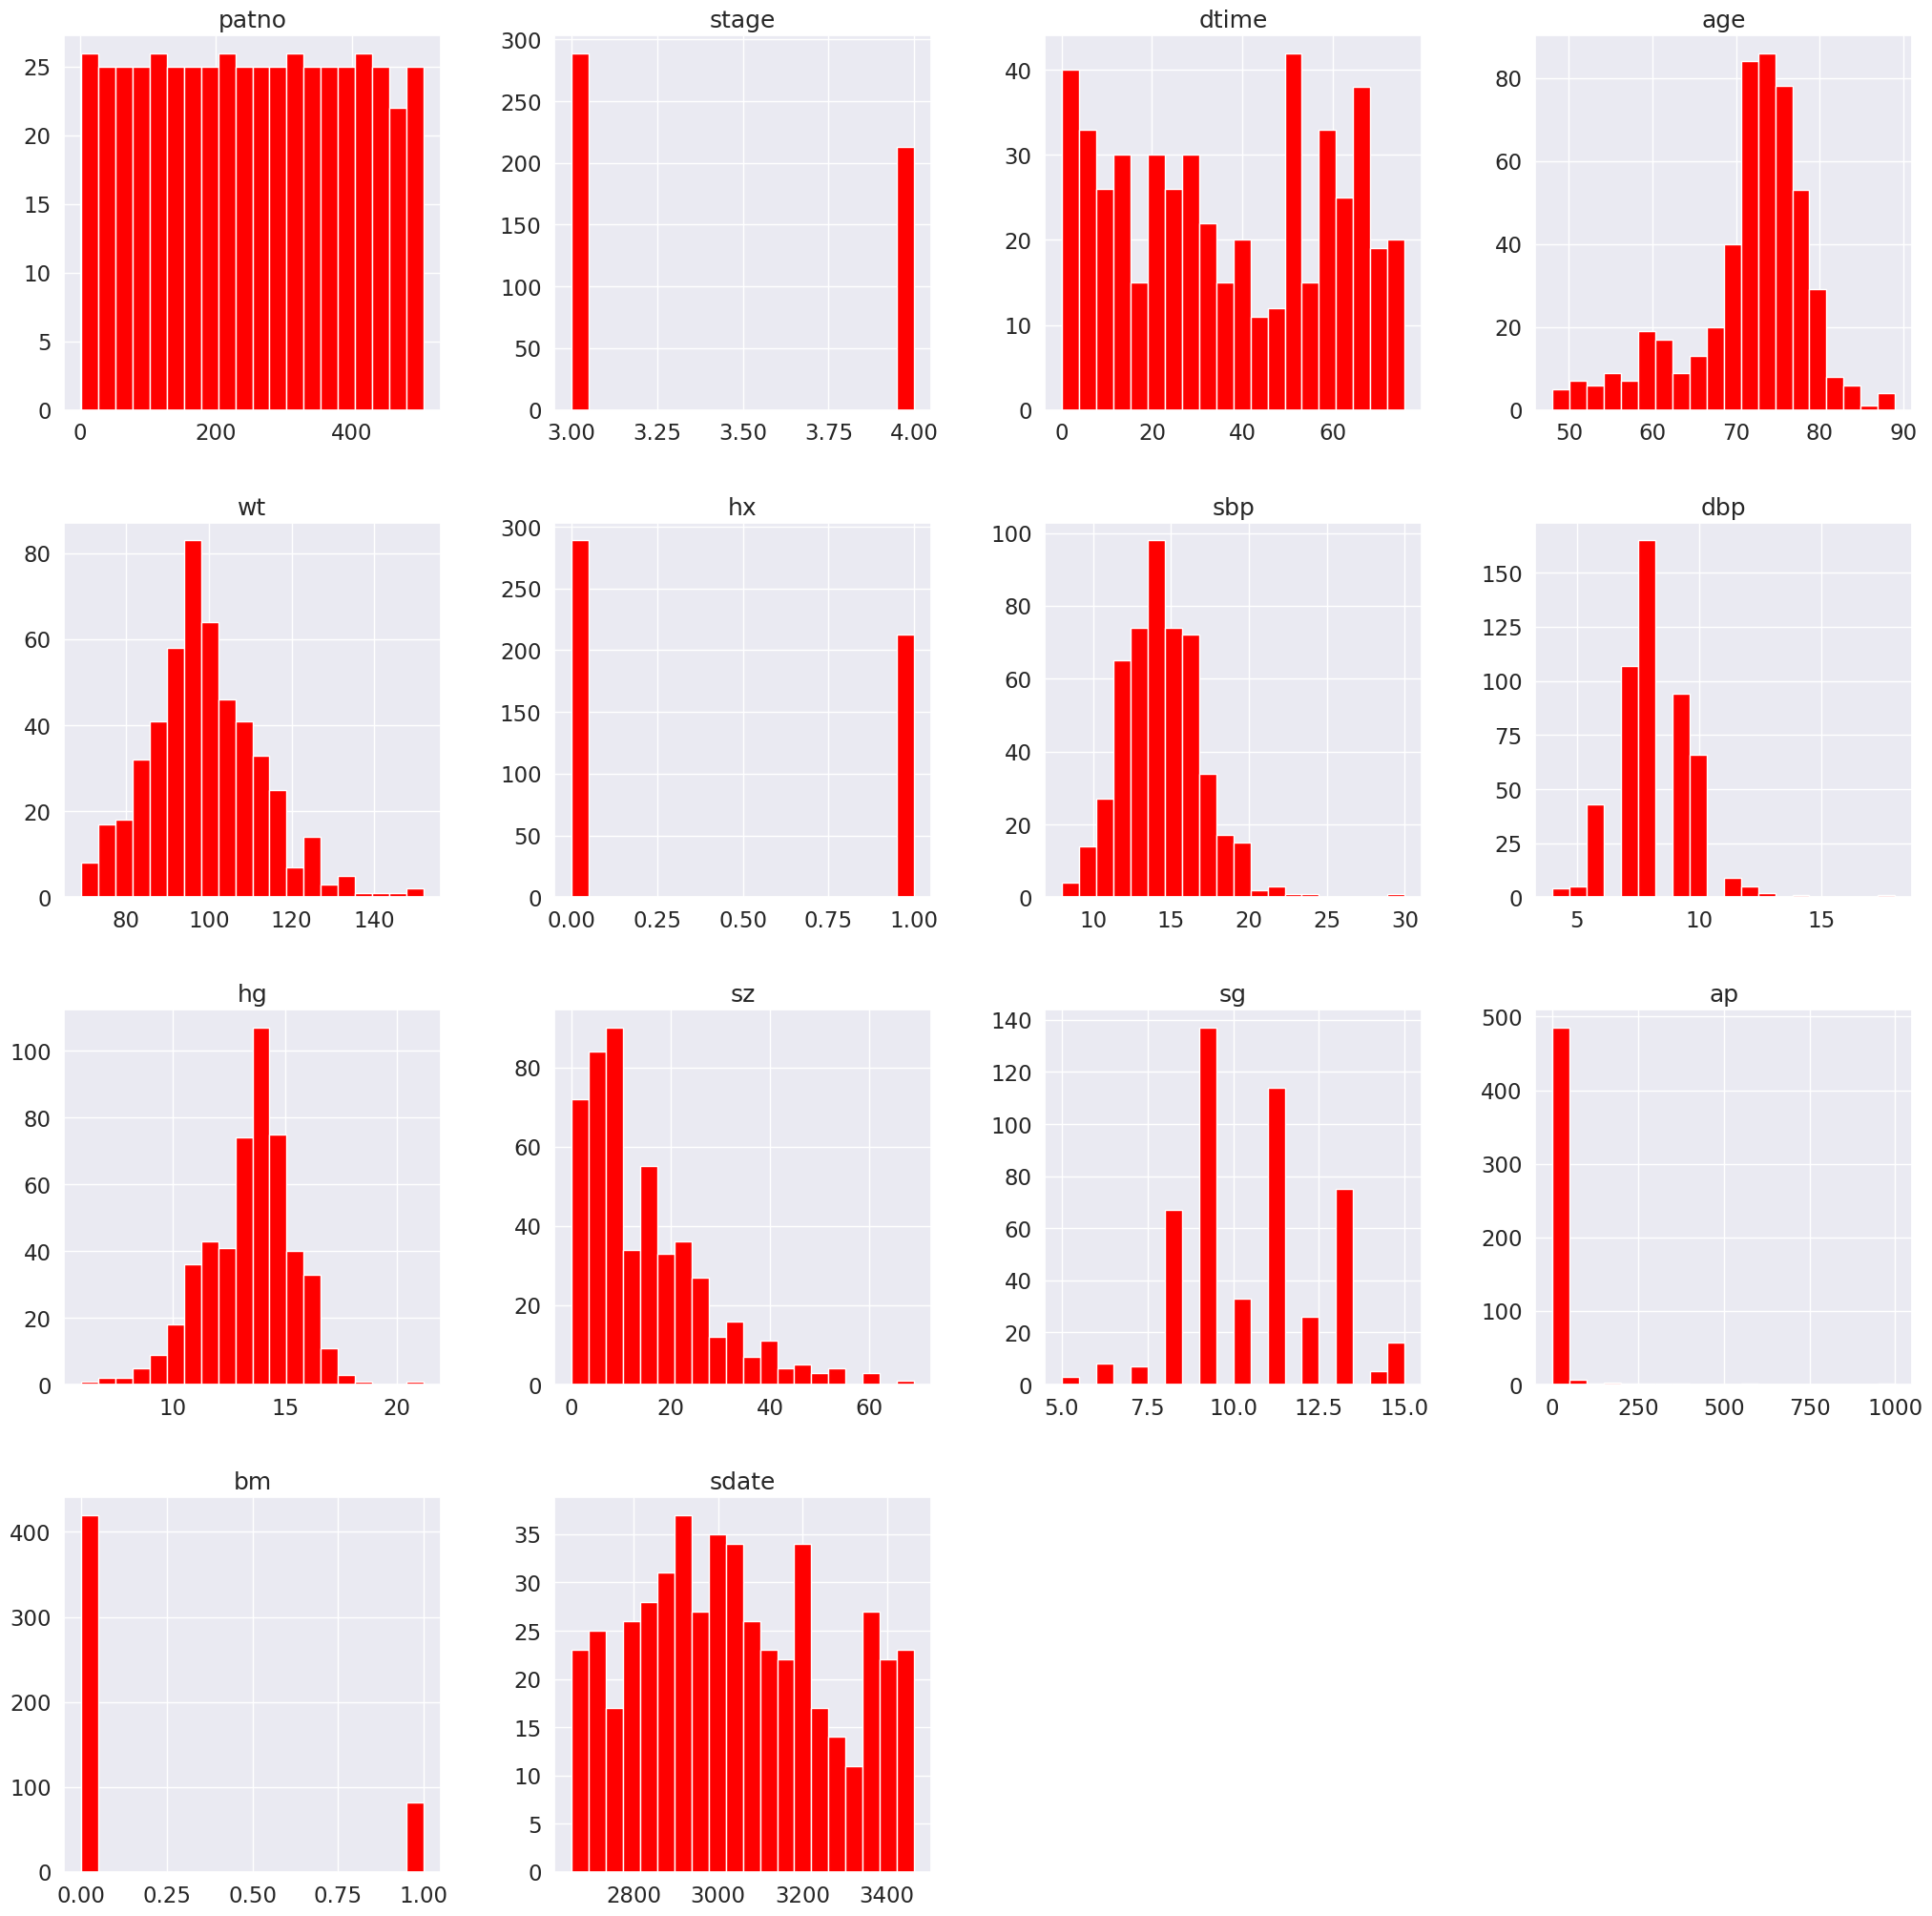

In [8]:
sns.set(font_scale=1.5,rc={'figure.figsize':(25,25)}) #usando a biblioteca sns posso verificar algumas distribuições dos meus dados
eixo=Dataset.hist(bins=20,color='red')

# Processing Some Variables

# Model Development and Results - Pipeline

In [50]:

list_to_drop=['patno','stage','dtime']

#list_to_drop_percentage=percent_missing[percent_missing > 20].index
#Dataset.drop(list_to_drop_percentage,axis=1,inplace=True)
Dataset.drop(list_to_drop,axis=1,inplace=True)

processor = processing_data(base=Dataset.copy())
variavel='status'
target='alive'
type_method='mean'
dummies=list(Dataset.select_dtypes(include=['object']).columns)
dummies.remove('status')
#var_int=['Tumor Purity']
#str_var=['hg','ap']
multiclass=False
'''
main_pipeline=Pipeline([#('float_values', FunctionTransformer(processor.float_values,kw_args={'str_var':str_var}
                         #                                    validate=False)),
                        ('target variable', FunctionTransformer(processor.target_variable,
                                             kw_args={'variavel': variavel, 'target':target, 'multiclass':multiclass})),
                       # ('Dummies', FunctionTransformer(processor.dummy_df,
                       #                     kw_args={'dummies': dummies},validate=False)),
                        ('Imput Values', FunctionTransformer(processor.impute_values,kw_args={'type_method':type_method},
                                                             validate=False)),
                        ('Normalize', FunctionTransformer(processor.normalize_df,
                                                          kw_args={'variavel': variavel},
                                                          validate=False)),

                        ])
X,y,Lista_variaveis=main_pipeline.fit_transform(Dataset)
'''

"\nmain_pipeline=Pipeline([#('float_values', FunctionTransformer(processor.float_values,kw_args={'str_var':str_var}\n                         #                                    validate=False)),\n                        ('target variable', FunctionTransformer(processor.target_variable,\n                                             kw_args={'variavel': variavel, 'target':target, 'multiclass':multiclass})),\n                       # ('Dummies', FunctionTransformer(processor.dummy_df,\n                       #                     kw_args={'dummies': dummies},validate=False)),\n                        ('Imput Values', FunctionTransformer(processor.impute_values,kw_args={'type_method':type_method},\n                                                             validate=False)),\n                        ('Normalize', FunctionTransformer(processor.normalize_df,\n                                                          kw_args={'variavel': variavel},\n                                        

In [51]:
main_pipeline=Pipeline([
                        #('int_values', FunctionTransformer(processor.int_values,
                        #                    kw_args={'str_var': var_int},
                        #                    validate=False)),
                        #('float_values', FunctionTransformer(processor.float_values,kw_args={'str_var': str_var},
                        #                                     validate=False)),
                        ('target variable', FunctionTransformer(processor.target_variable,
                                            kw_args={'variavel': variavel, 'target':target, 'multiclass':multiclass},
                                            validate=False)),
                        ('Dummies', FunctionTransformer(processor.dummy_df,
                                            kw_args={'dummies': dummies},
                                            validate=False)),
                        ])

# Fit and transform the data using the pipeline
transformed_data = main_pipeline.fit_transform(Dataset)
X=processor.impute_values(transformed_data,type_method)
X,y,Lista_variaveis=processor.normalize_df(X,variavel)

Text(0.5, 1.0, 'Correlation Graph between Variables \n')

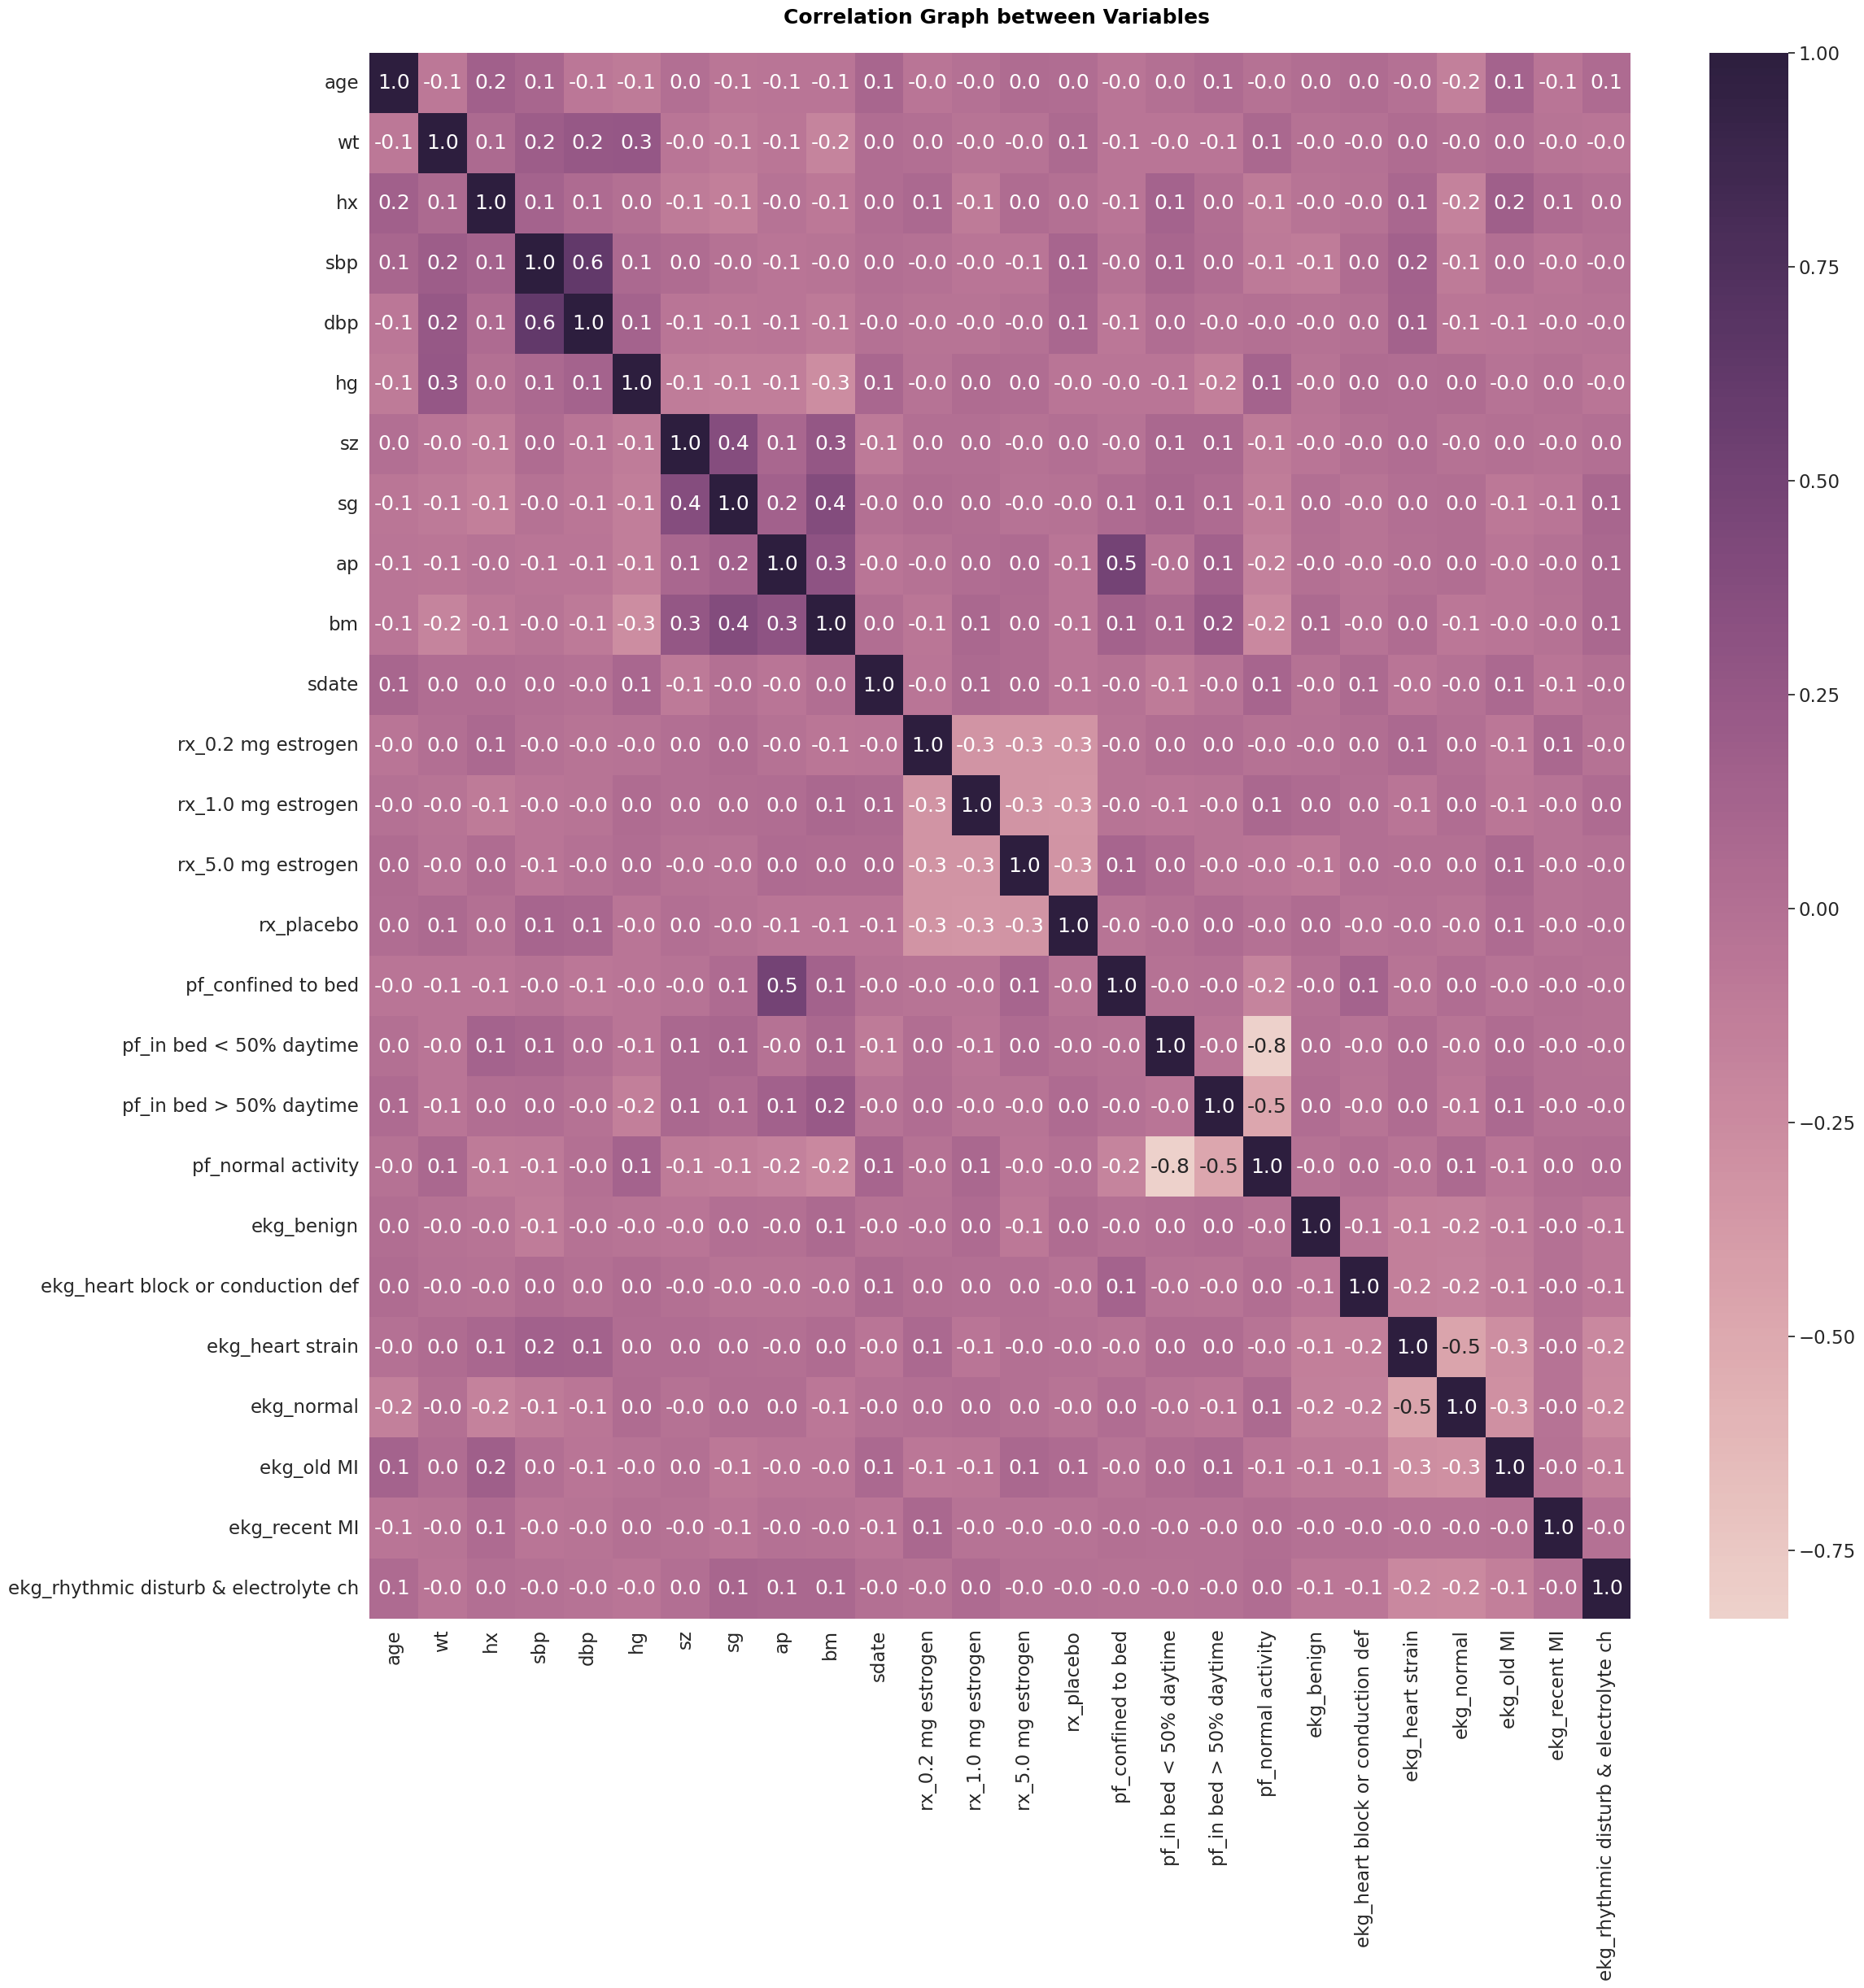

In [20]:
# Create correlation matrix
X_df = pd.DataFrame(X, columns=Lista_variaveis)  # Specify Lista_variaveis as columns
corr_mat = X_df.corr()

# Plot heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(corr_mat, annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200))
plt.title('Correlation Graph between Variables \n', weight="bold", color="#000000", fontsize=18)

Text(0.5, 1.0, 'Correlation Graph between Variables \n')

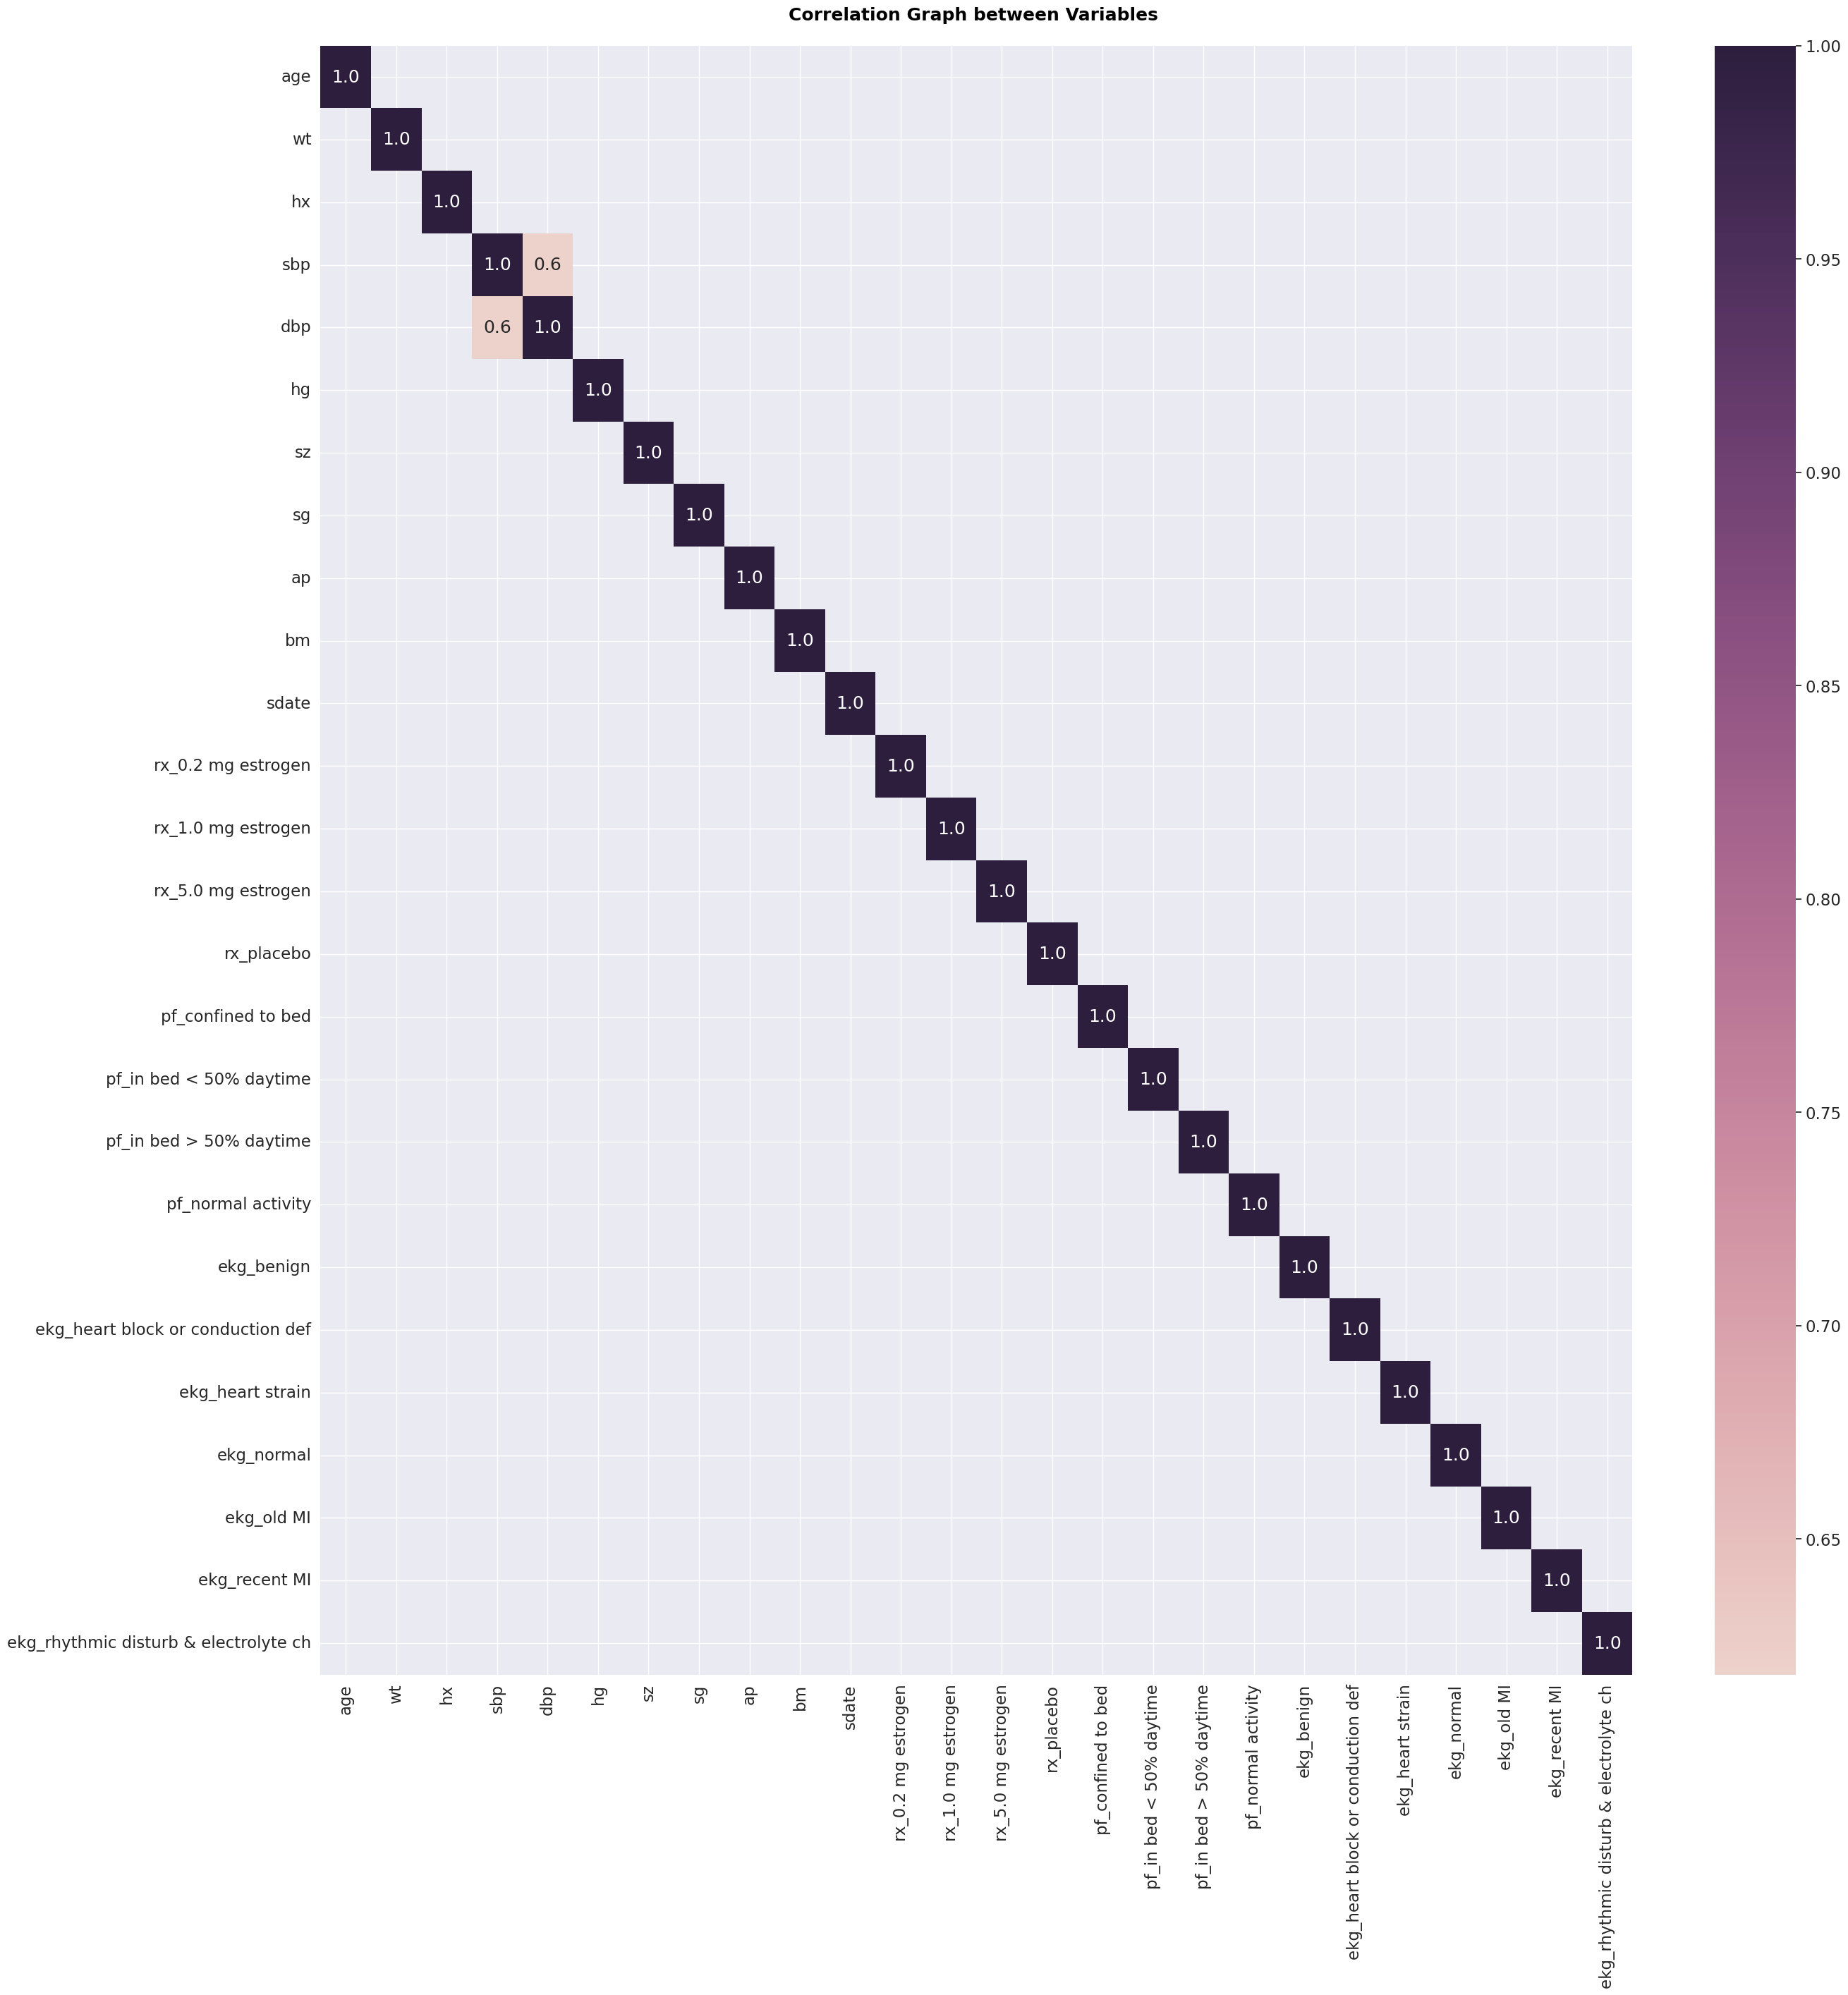

In [21]:
plt.figure(figsize=(30, 30))
sns.heatmap(corr_mat[corr_mat > 0.5], annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200))
plt.title('Correlation Graph between Variables \n', weight="bold", color="#000000", fontsize=18)

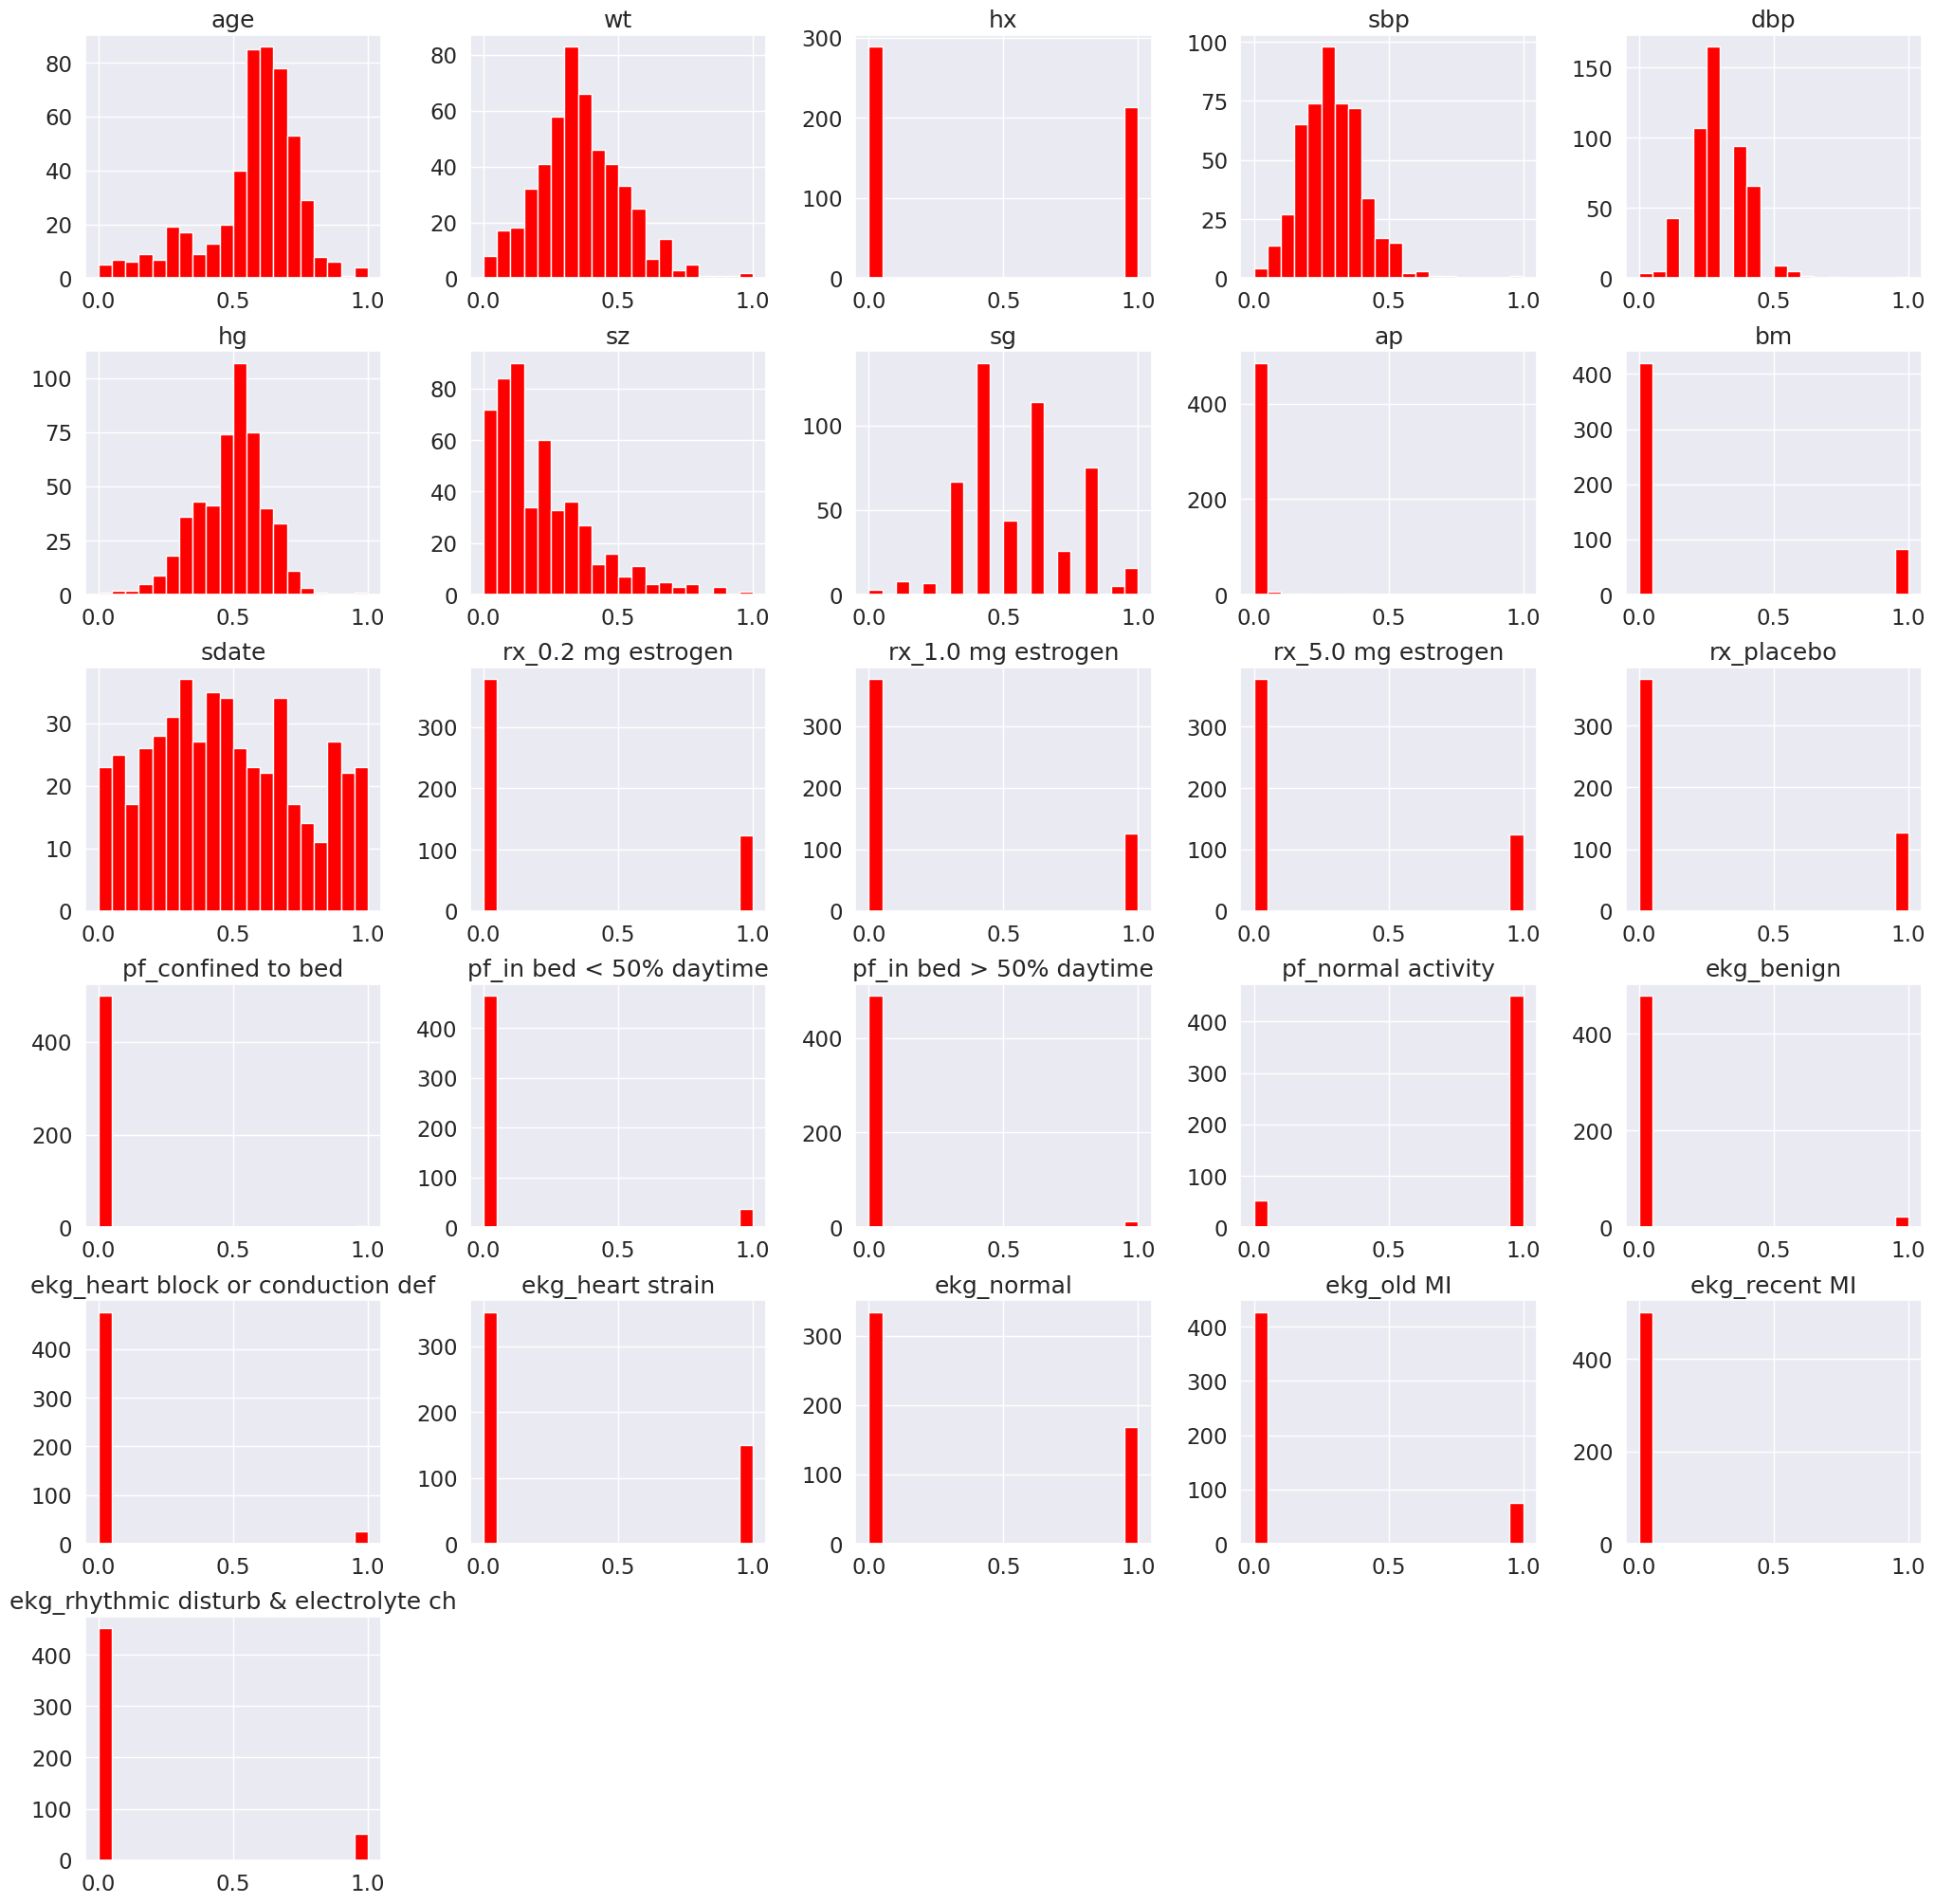

In [13]:
sns.set(font_scale=1.5,rc={'figure.figsize':(25,25)}) #usando a biblioteca sns posso verificar algumas distribuições dos meus dados
eixo=X_df.hist(bins=20,color='red')

In [22]:
import plotly.express as px

# Convert X to a pandas DataFrame with column names
X_df = pd.DataFrame(X, columns=Lista_variaveis)
X_df['target'] = y

# Create the histogram using the DataFrame and color mapping
histogram_diagnosis = px.histogram(
    X_df,
    x='target',
    color=X_df['target'],  # Map target values to colors
    title='Count Cases',
    text_auto=True,
)
histogram_diagnosis.show()

In [23]:
import plotly.express as px
fig = px.pie(X_df, names='target', title='Percentage',color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

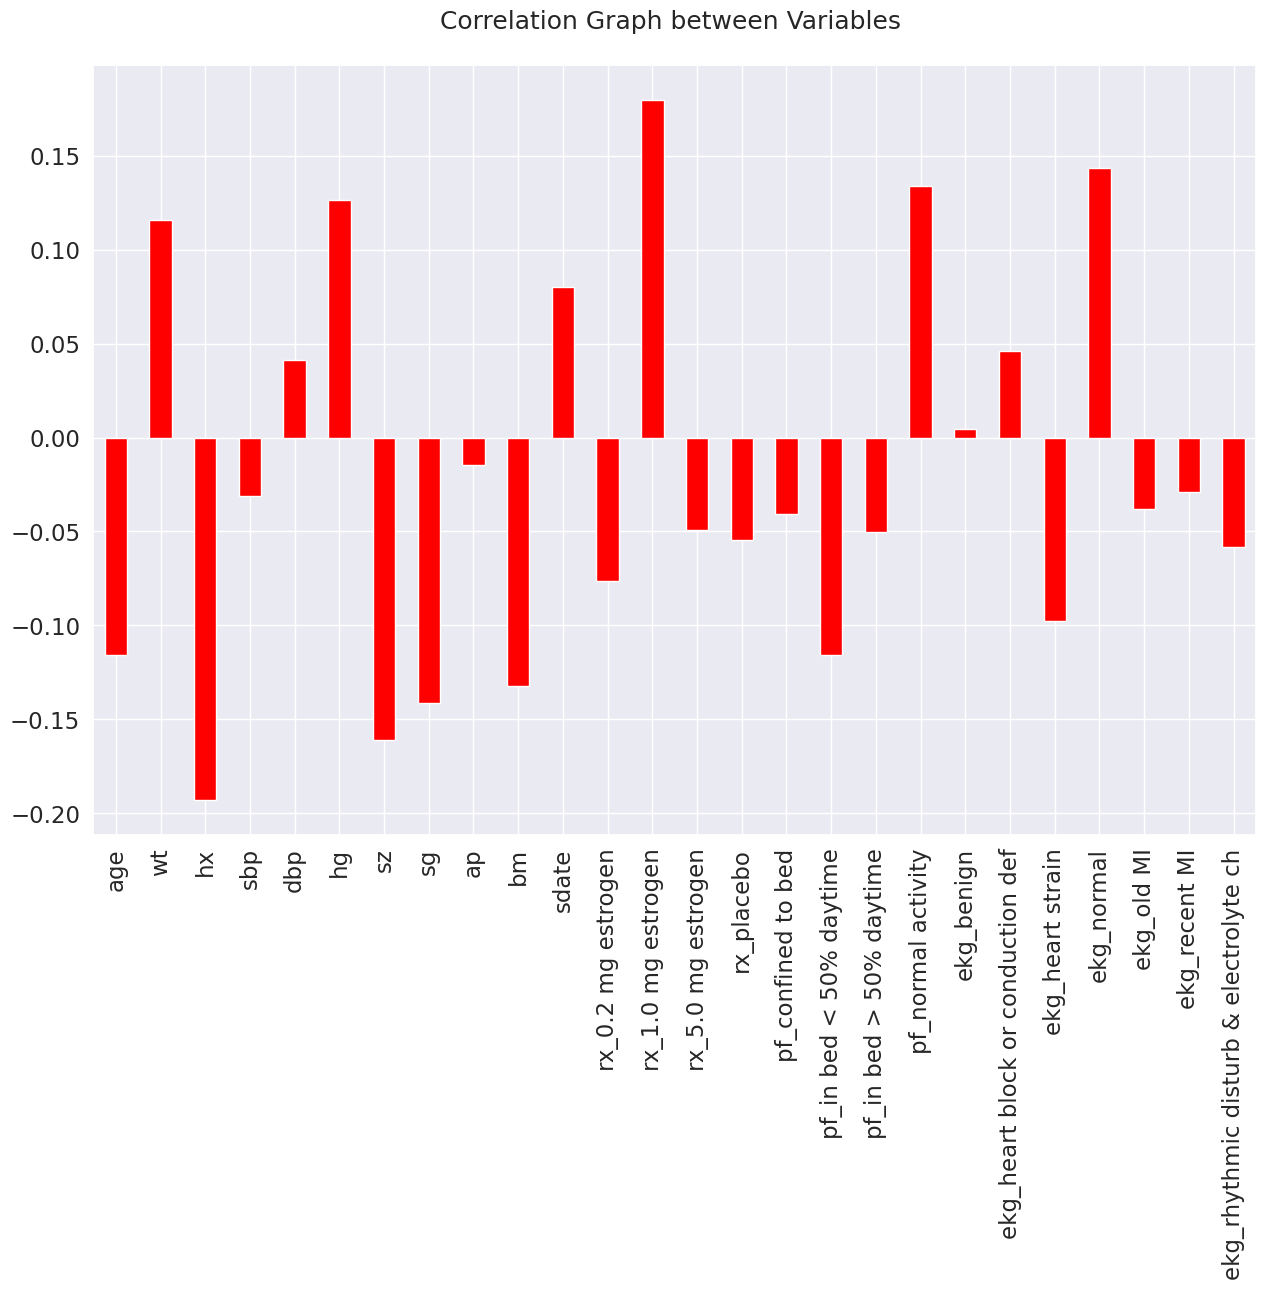

In [24]:
features = X_df.drop('target', axis=1)

correlation_with_diagnosis = features.corrwith(X_df['target'])
correlation_with_diagnosis.plot(kind='bar', grid=True, figsize=(15, 10), title="Correlation Graph between Variables \n", color="red")
plt.show()

In [60]:
batch_size=4
epochs=10
clusters=2
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5521 - loss: 0.7668
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6493 - loss: 0.6314
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6490 - loss: 0.6455
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6761 - loss: 0.6094
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7055 - loss: 0.5809
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6845 - loss: 0.5958
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7197 - loss: 0.5906
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7135 - loss: 0.6311
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7071 - loss: 0.6045
Epoch 10/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7010 - loss: 0.6125

Model Accuracy: 73.27%

F1 Score: 0.00%

Recall Score:0.00%



Confussion Matrix


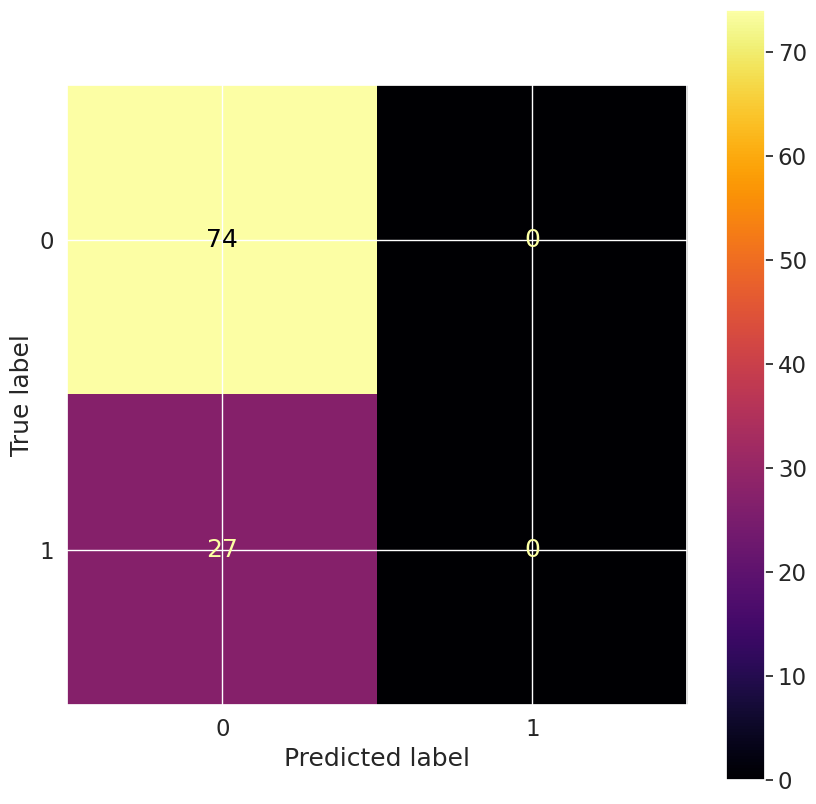


                                   feature  importance
0                                     age         0.0
1                                      wt         0.0
2                                      hx         0.0
3                                     sbp         0.0
4                                     dbp         0.0
5                                      hg         0.0
6                                      sz         0.0
7                                      sg         0.0
8                                      ap         0.0
9                                      bm         0.0
10                                  sdate         0.0
11                     rx_0.2 mg estrogen         0.0
12                     rx_1.0 mg estrogen         0.0
13                     rx_5.0 mg estrogen         0.0
14                             rx_placebo         0.0
15                     pf_confined to bed         0.0
16                pf_in bed < 50% daytime         0.0
17                pf_in be

In [61]:
#Neural Network
type_model='Neural Network'
processor_Neuro = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,batch_size=batch_size,epochs=epochs)
model = processor_Neuro.neuro_model()
processor_Neuro.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)

Best Parameter to criterion entropy
Best Parameter to max_depth 5

Model Accuracy: 63.37%

F1 Score: 44.78%

Recall Score:55.56%



Confussion Matrix


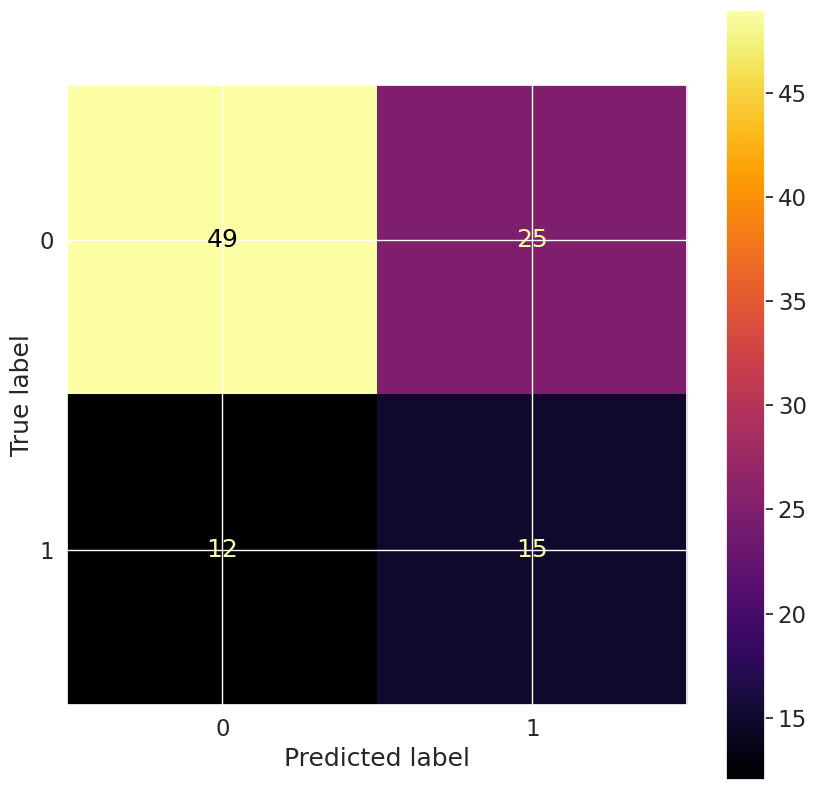


 Feature Importance
importance    26
dtype: int64


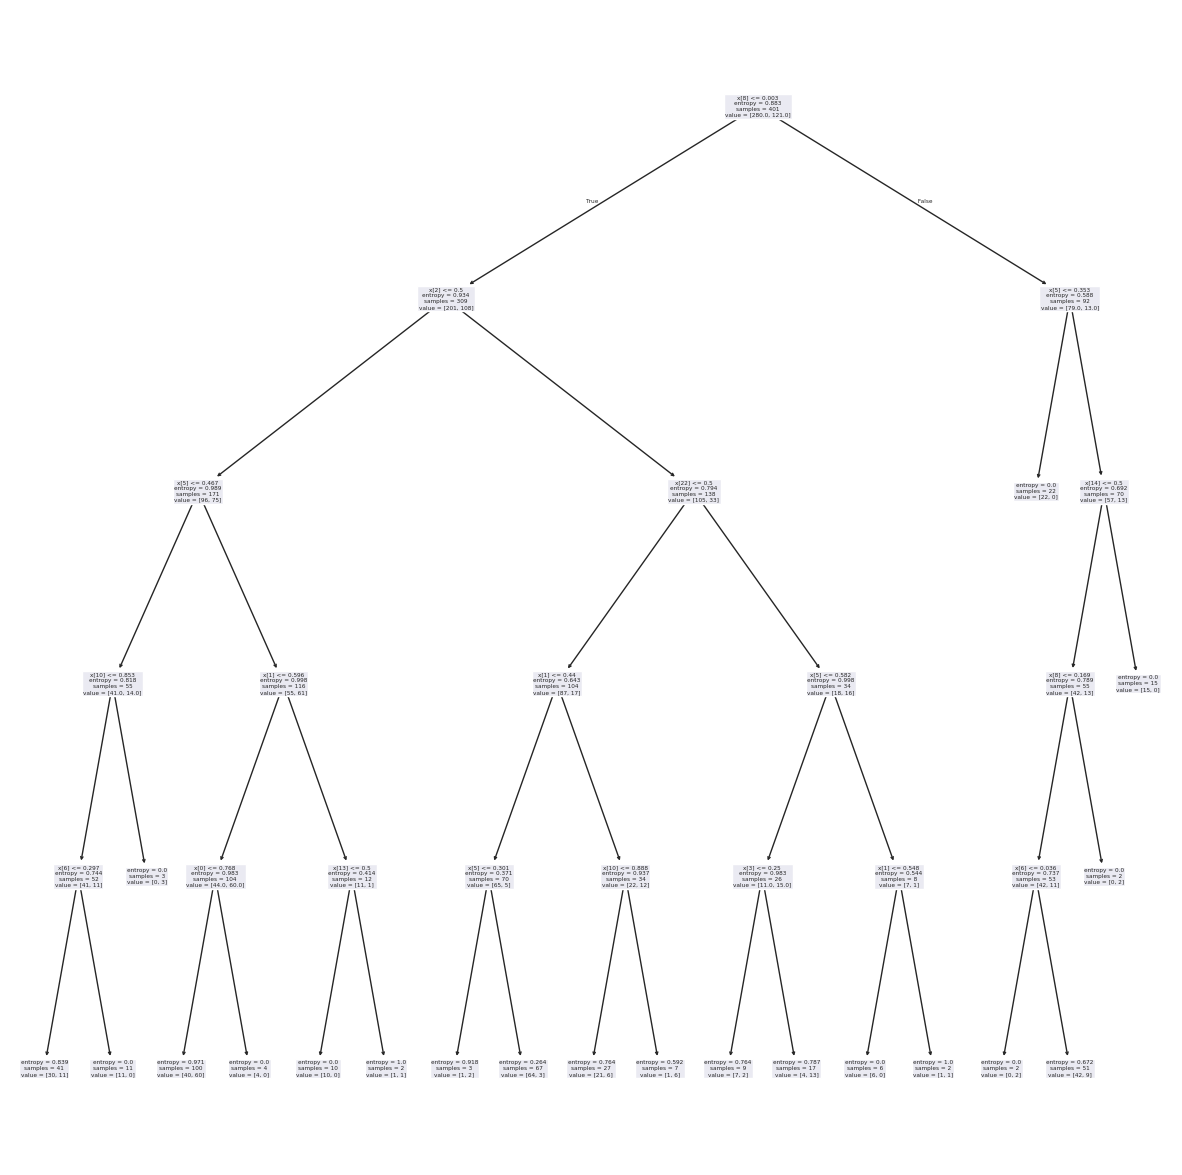

In [62]:
#Decission Tree
type_model='Decission Tree'
processor_decission_tree = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,model_tree='Decission Tree')
model= processor_decission_tree.tree_and_random_forest()
processor_decission_tree.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)

Best Parameter to n_estimators 50
Best Parameter to max_depth 4

Model Accuracy: 75.25%

F1 Score: 19.35%

Recall Score:11.11%



Confussion Matrix


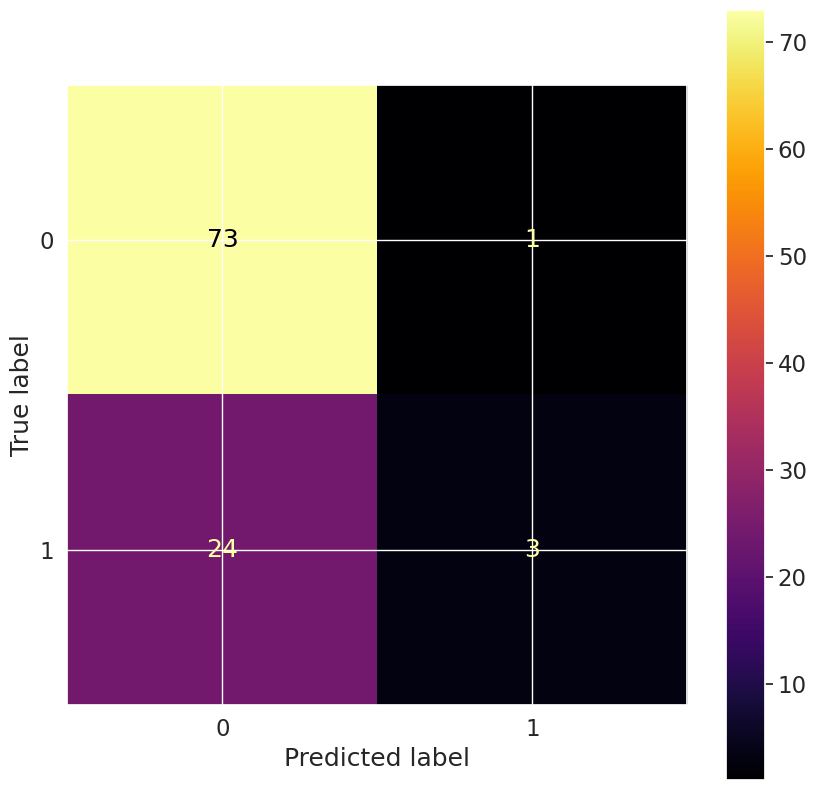


 Feature Importance
importance    26
dtype: int64


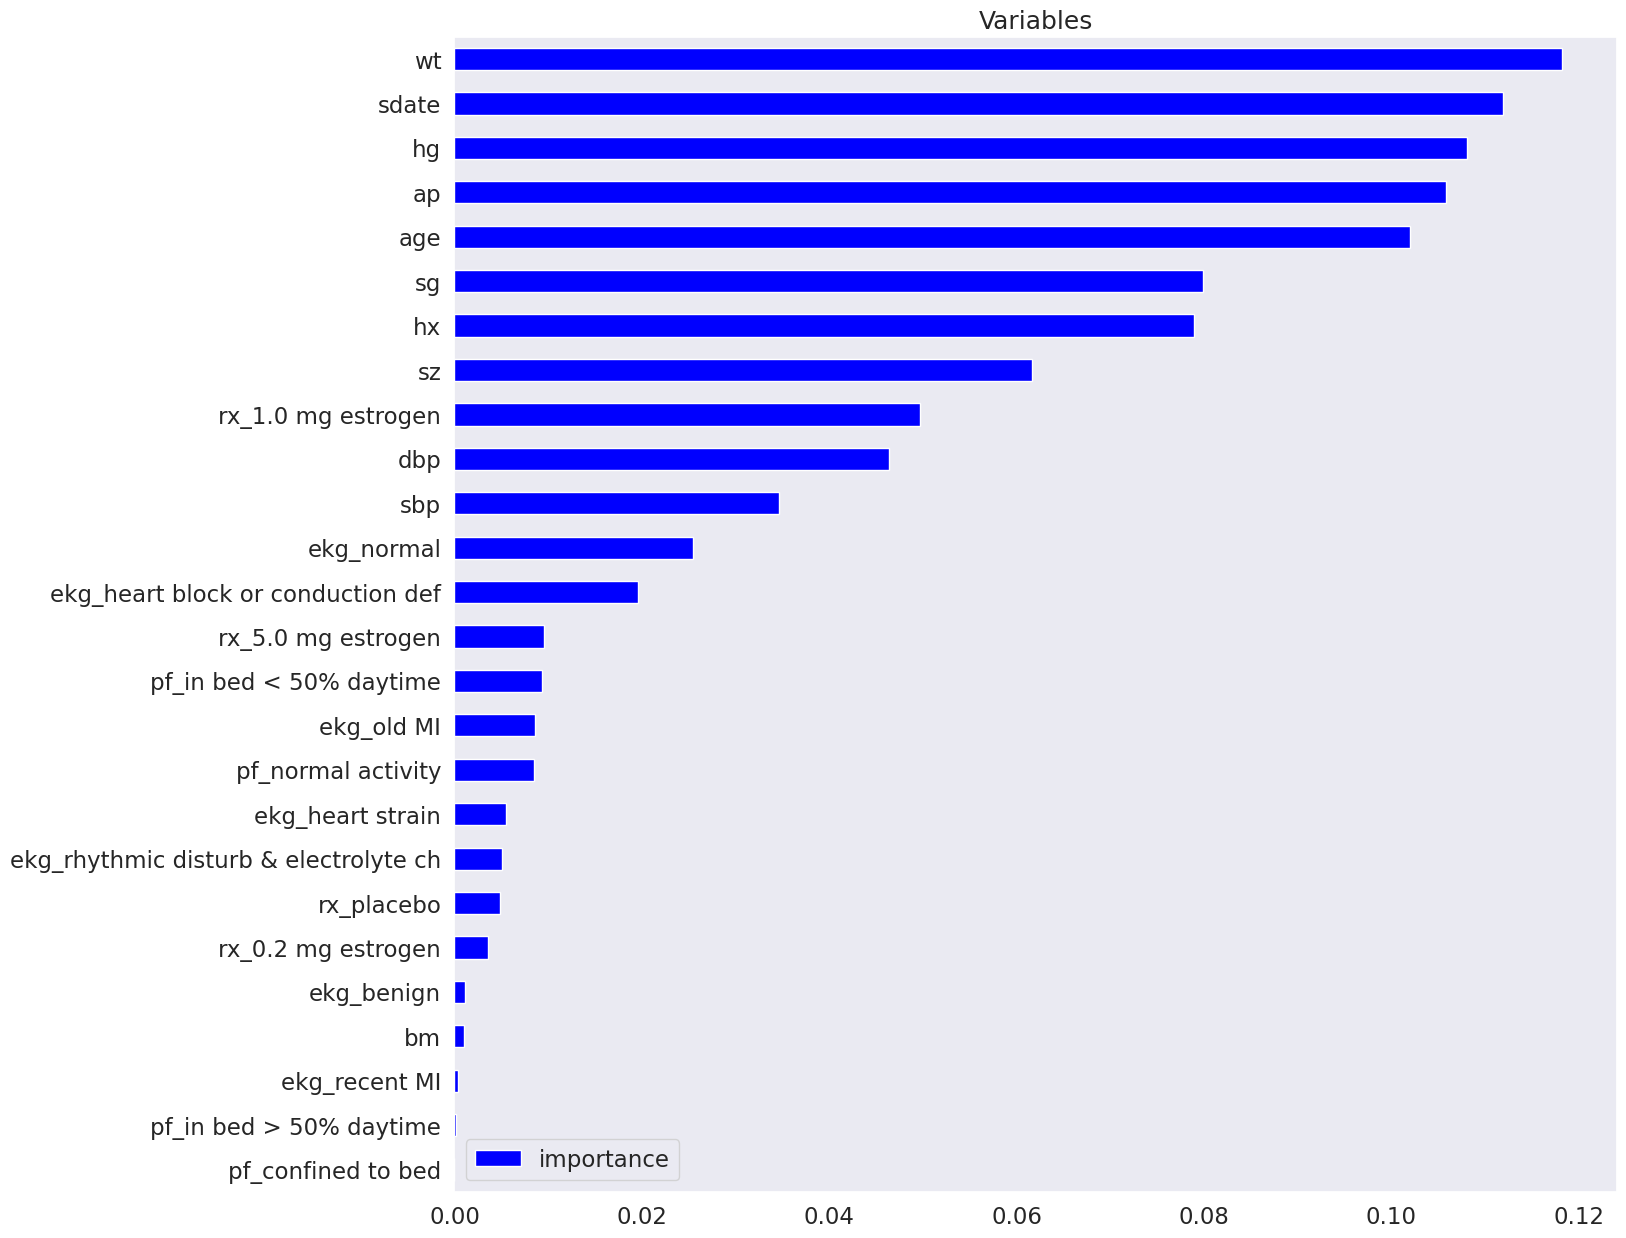

In [63]:
#Random Forest
type_model='Random Forest'
processor_randomf = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,model_tree='Random Forest')
model= processor_randomf.tree_and_random_forest()
processor_randomf.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)

Best Parameter to solver sag
Best Parameter to max_inter 10

Model Accuracy: 76.24%

F1 Score: 36.84%

Recall Score:25.93%



Confussion Matrix


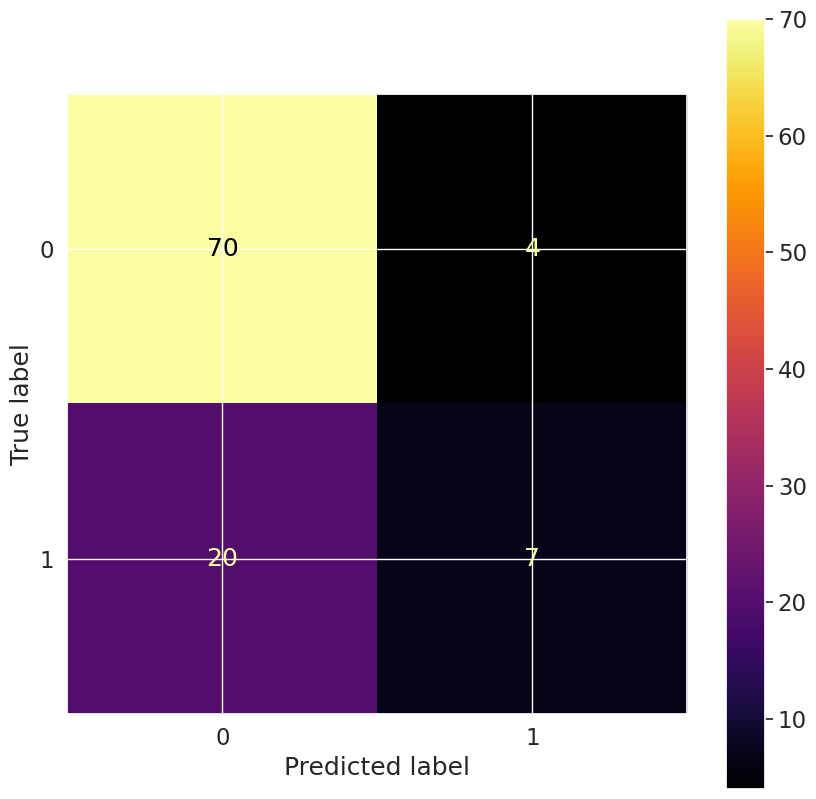


 Feature Importance


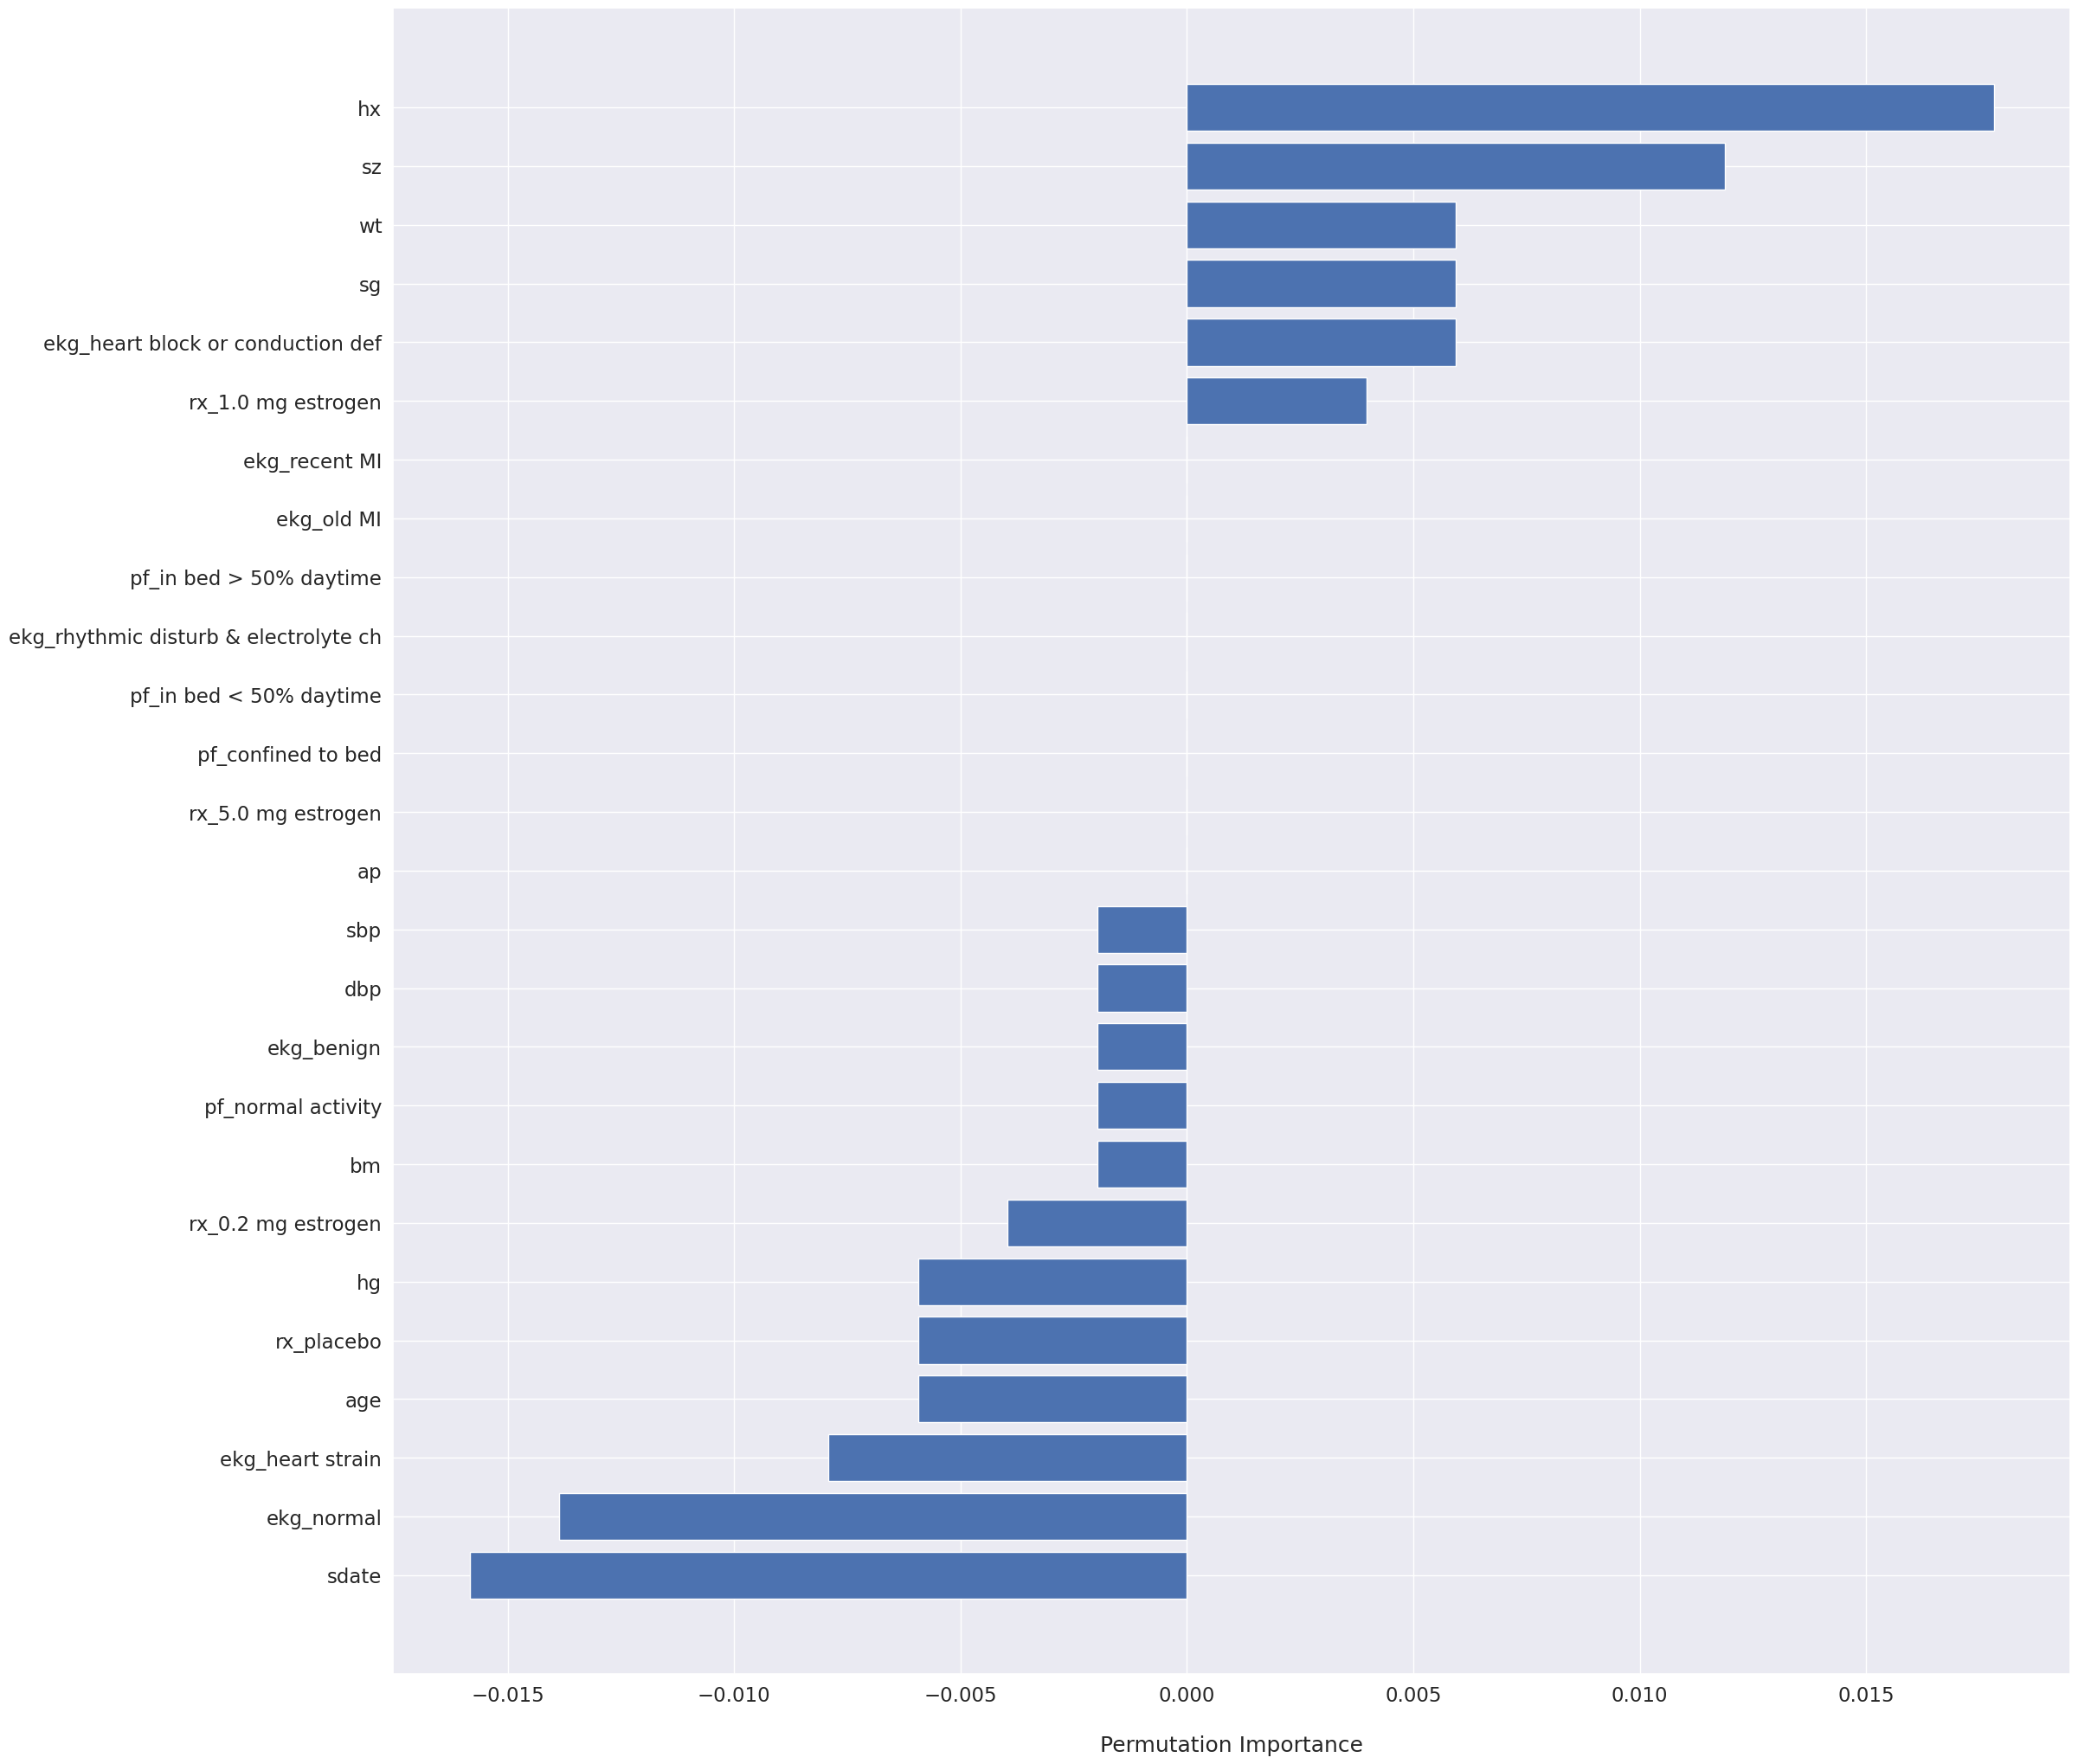

In [66]:
#Logistic Model
type_model='Regression Logistic'
processor_logistic = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis)
model= processor_logistic.logistic_model()
processor_logistic.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)


Model Accuracy: 77.23%

F1 Score: 25.81%

Recall Score:14.81%



Confussion Matrix


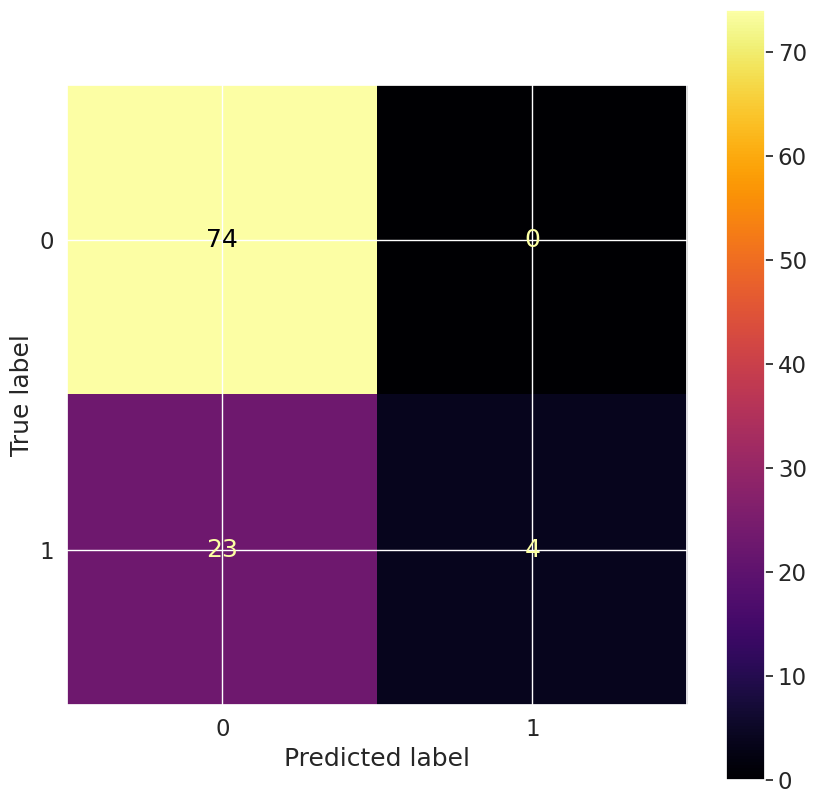


 Feature Importance


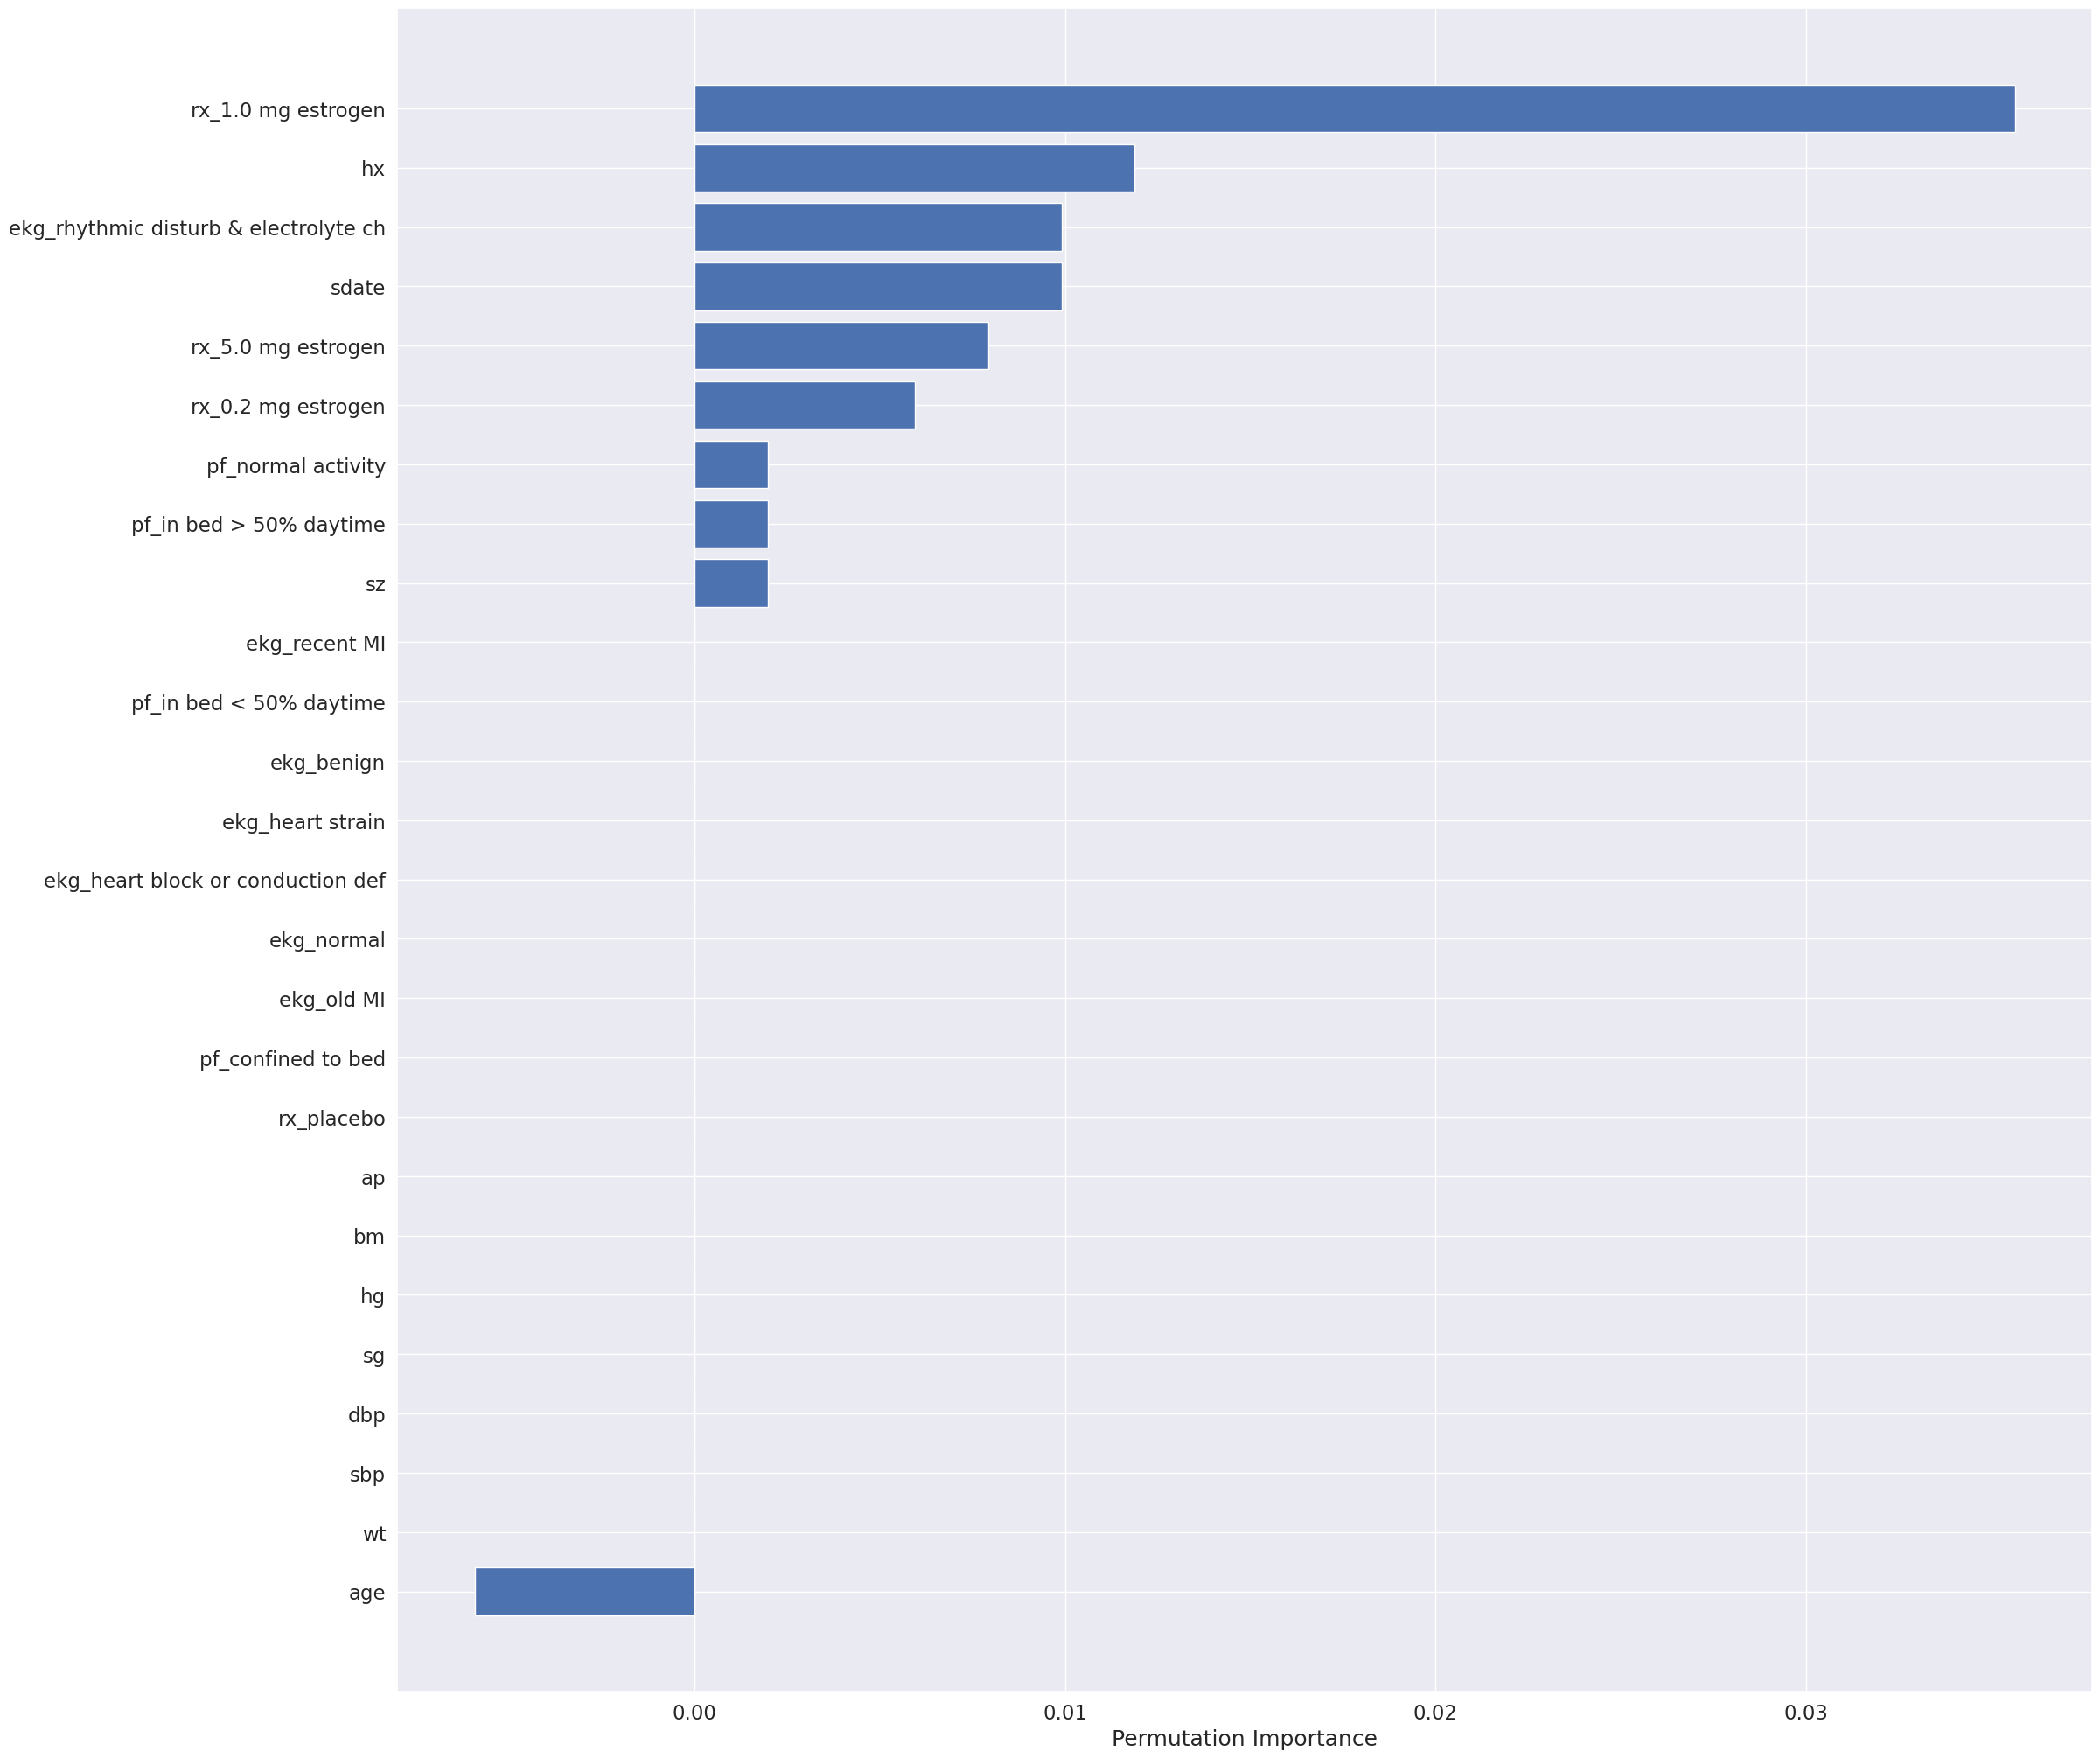

In [67]:
#SVM Model
type_model='SVM'
processor_svm = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis)
model= processor_svm.svm_model()
processor_svm.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)


Best Parameter to n_neighbors 2
Best Parameter to p 2

Model Accuracy: 73.27%

F1 Score: 22.86%

Recall Score:14.81%



Confussion Matrix


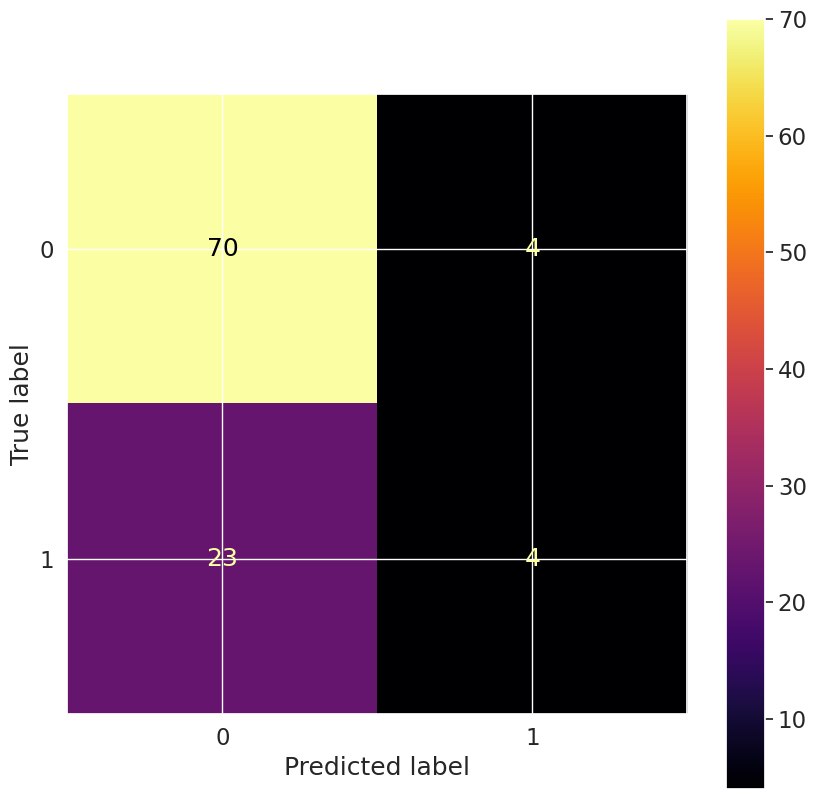


 KNN model does not have feature importance


In [68]:
#KNN Model
type_model='KNN'
processor_knn = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis)
model= processor_knn.knn_model()
processor_knn.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)

In [ ]:
#PCA Method

#for k in range(2,len(Lista_variaveis)//2):
pca=PCA(n_components=3)
XTrain = pca.fit_transform(Xtrain)
XTest = pca.transform(Xtest)

processor_randomf = models_types(X=XTrain,y=ytrain,Lista_variaveis=Lista_variaveis,model_tree='Random Forest')
model= processor_randomf.tree_and_random_forest()
processor_randomf.models_metrics(model, XTrain, ytrain, XTest, ytest)
#processor_randomf.models_metrics_random_tree(model, XTrain, ytrain, XTest, ytest)


Best Parameters 20 5

 KS Validation: 71.43% e AUC: 98.29%

  (np.float64(0.9555275), np.float64(0.0))

  KS Development: 63.41% e AUC: 99.76%

 (np.float64(0.9909091), np.float64(0.0))


In [ ]:
predition_1 = model.predict(XTest)
model_RandomForest_acc = accuracy_score(ytest, predition_1)
print("\nModel Accuracy: {:.2%}".format(model_RandomForest_acc))


Model Accuracy: 93.86%


In [ ]:
pca=PCA(n_components=3)
pca.fit(XTest)
X_pca=pca.transform(XTest)
base=pd.DataFrame(data=X_pca,columns=['PC1','PC2','PC3'])
base['Cluster']=model.predict(XTest)
base
color_theme = np.array(['red','green'])


In [ ]:
df = base
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
              color=color_theme[base['Cluster']])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
y_pred=model.predict(X, verbose=0)
y_pred = [np.argmax(v) for v in y_pred]
X1 = processor.min_max_scaler.inverse_transform(X)
df = pd.DataFrame(data=X1, columns=Lista_variaveis)
df2 = pd.DataFrame(data=y,columns=['Tarq'])
df3 = pd.DataFrame(data=y_pred,columns=['Pred'])
df = pd.concat([df,df2,df3],axis=1)


In [ ]:
df.round(decimals=2).to_csv('df.csv',index=False)